# Introduction & Background Research
## Context
This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. [1](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

There are 10 classes of data:
<br>

| Label | Description |
|---|---|
| 0 | T-Shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9|Ankle boot|


Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."

Zalando seeks to replace the original MNIST dataset


## Content
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

Hence:
- Each row is a separate image
- Column 1 is the class label.
- Remaining columns are pixel numbers (784 total).
- Each value is the darkness of the pixel (1 to 255)



In [1]:
from IPython.core.display import Image
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, Input,Conv2D,Flatten,AveragePooling2D,MaxPooling2D,Dropout,Activation,GlobalAveragePooling2D,Rescaling,BatchNormalization
from matplotlib import pyplot as plt
import visualkeras
from PIL import ImageFont
import tensorflow_data_validation as tfdv
import keras_cv

In [2]:
# packages to install
# !pip install graphwiz
# !pip install tensorflow_datasets
# !pip install visualkeras

In [3]:
# Configuration for TF to run on GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.get_logger().setLevel('ERROR')
# global parameters
SEED = tf.random.set_seed(23)
IMG_SIZE =(28,28,1)

# Data Ingestion & Exploration

## Importing Data
We load the Fashion MNIST Dataset using `tfds.load()` as it allows us to split the data into 3 sets: Train, Validation and Test

as seen on [StackAbuse](https://stackabuse.com/split-train-test-and-validation-sets-with-tensorflow-datasets-tfds/) and [YouTube](https://www.youtube.com/watch?v=YrMy-BAqk8k)


Train set size:  50000
Valid set size:  10000
Test set size:  10000


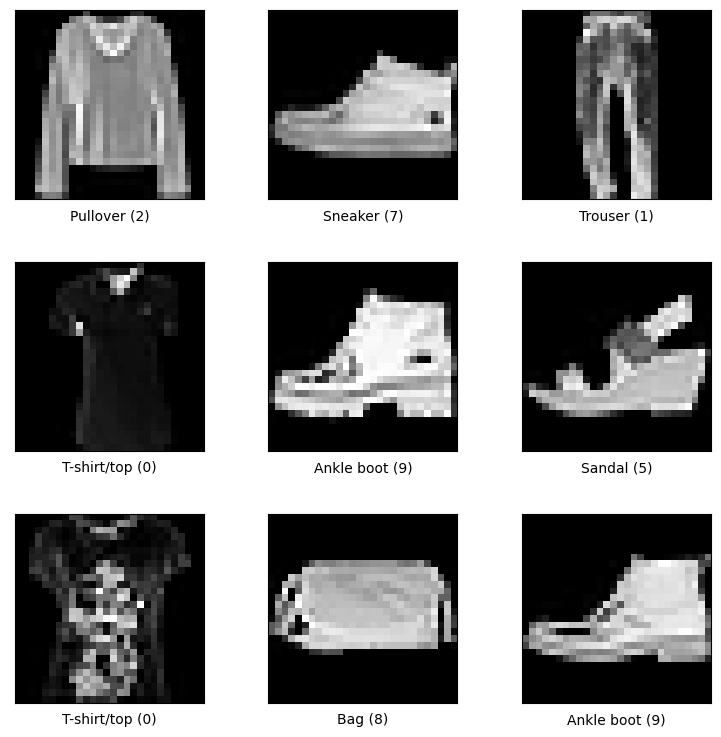

In [4]:
(test_set, valid_set, train_set),info= tfds.load("fashion_mnist",
                                           split=["test", "train[0:10000]", "train[10000:]"],as_supervised=True,with_info=True,shuffle_files=True,data_dir=r"../part_a/data")

print("Train set size: ", len(train_set)) # Train set size:  50000
print("Valid set size: ", len(valid_set)) # Valid set size:  10000
print("Test set size: ", len(test_set))   # Test set size:  10000
tfds.show_examples(train_set,info,rows=3,cols=3)
class_names = np.loadtxt(r"../part_a/data/fashion_mnist/3.0.1/label.labels.txt",dtype=str,delimiter=",")


In [5]:
train_set

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Exploratory Data Analysis (EDA)
We can observe that


# Data Preprocessing

## Normalisation
Image normalization is done to the dataset.

Normalizing follows the formula below

$$
X_{} = \frac{X_{} - μ_{}}{σ_{}}
$$

This ensures pixel values for each pixel are on a similar scale, helping the optimization algorithm to better converge during gradient descent.
<br>

### Batch Normalisation
Batch Normalization focuses on standardizing the inputs to any particular layer(i.e. activations from previous layers). Standardizing the inputs mean that inputs to any layer in the network should have approximately zero mean and unit variance. (Vijayrania, 2021)

Mathematically, BN layer transforms each input in the current mini-batch by subtracting the input mean in the current mini-batch and dividing it by the standard deviation (Vijayrania, 2021)


$$
z^N = \frac{z-m_z}{s_z}
$$

Batch Norm is a normalization technique done between the layers of a Neural Network instead of in the raw data. It is done along mini-batches instead of the full data set. It serves to speed up training and use higher learning rates, making learning easier. [4](https://www.baeldung.com/cs/batch-normalization-cnn)


Vijayrania, N. (2021). Different Normalization Layers in Deep Learning. [online] Medium. 

Available at: https://towardsdatascience.com/different-normalization-layers-in-deep-learning-1a7214ff71d6.

###  Weight Normalisation
Weight normalisation decouples the length from the direction of the weight vector and hence reparameterize the network to speed up the training. (Vijayrania, 2021)

The authors of the Weight Normalization paper suggested using two parameters g(for length of the weight vector) and v(the direction of the weight vector) instead of w for gradient descent in the following manner. (Vijayrania, 2021)

$$
w = \frac{g}{||v||}v
$$

Weight Normalization speeds up the training similar to batch normalization and unlike BN, it is applicable to RNNs as well. But the training of deep networks with Weight Normalization is significantly less stable compared to Batch Normalization and hence it is not widely used in practice. (Vijayrania, 2021)



## Data Augmentation

The data augmentation will be done on the fly on the CPU as the GPU is training the model, meaning that while it is training the current batch, it will fetch the next batch of data and perform the augmentation in real time.

We will be trying out different data augmentation methods such as
1. CutMix
2. MixUp
3. RandomXXX


## Data Prefetching
Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step `s`, the input pipeline is reading the data for step `s+1`.

Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

![prefetch](images/prefetched.png)
[Credit](https://www.tensorflow.org/guide/data_performance)


Now, as the data execution time plot shows, while the training step is running for sample 0, the input pipeline is reading the data for the sample 1, and so on.

[Credit](https://www.tensorflow.org/guide/data_performance)

## Custom Preprocessing Pipeline

We will be implementing a custom-made preprocessing pipeline to prepare and augment the data using CutMix as inspired by [Keras Documentation](https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/)

### CutMix & MixUp, Basic Augmentation
CutMix randomly cuts out portions of one image and places them over another, and MixUp interpolates the pixel values between two images

This prevents the model from overfitting the training distribution and improve the likelihood that the model can generalize to out of distribution examples.

Additionally, CutMix prevents our model from over-relying on any particular feature to perform its classifications. You can read more about these techniques in their respective papers.


We also use `tf.one_hot` to hard label encode our labels according to One-Hot Encoding. Hard label assignment is natural to us and maps to how our brains want to efficiently categorize and store information in neatly labeled and packaged boxes.

However, we don’t want our model to become too confident in its predictions. Hence, we apply soft label assignment.

Unlike hard label assignments where class labels are binary (i.e., positive for one class and a negative example for all other classes), soft label assignment allows:

- The positive class to have the largest probability
- While all other classes have a very small probability

Hence, we apply label smoothing. By doing so, we can lessen the confidence of the model and prevent it from descending into deep crevices of the loss landscape where overfitting occurs [as seen here](https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/).


In [6]:
class Preprocessing:
    def __init__(self):
        self.IMAGE_SIZE = (28, 28)
        self.num_classes = info.features["label"].num_classes
        self.BATCH_SIZE = 128
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.cut_mix = keras_cv.layers.CutMix()
        self.mix_up = keras_cv.layers.MixUp()
        self.ModelBuild = keras.models.Model

    # onehot encode and cat images
    def to_dict(self,image, label):
        image = tf.cast(image, tf.float32)
        label = tf.one_hot(label, self.num_classes)
        return {"images": image, "labels": label}

    # shuffle dataset, encode, batch datasets
    def prepare_dataset(self, dataset, split):
        if split == "train":
            return dataset.cache().shuffle(info.splits["train"].num_examples).map(self.to_dict, num_parallel_calls=self.AUTOTUNE).batch(self.BATCH_SIZE)

        if split == "test" or split=='valid':
            return dataset.batch(self.BATCH_SIZE).map(self.to_dict, num_parallel_calls=self.AUTOTUNE)

    # perform CutMix & MixUp data augmentation
    def cut_mix(self,samples):
        samples = self.cut_mix(samples, training=True)
        return samples

    def mix_up(self,samples):
        samples = self.mix_up(samples, training=True)
        return samples

    # call data augmentation when ready
    def augment(self,dataset,aug_type):
        if aug_type == 'cut':
            return dataset.map(self.cut_mix, num_parallel_calls=self.AUTOTUNE)
        elif aug_type =='up':
            return dataset.map(self.mix_up, num_parallel_calls=self.AUTOTUNE)
        elif aug_type == 'basic':
            input1 = layers.Input(shape=(28, 28, 1))
            x = layers.RandomFlip("horizontal")(input1)
            x = layers.RandomRotation(factor=0.15)(x)
            output = layers.RandomZoom(height_factor=0.2, width_factor=0.2)(x)
            basic_augmentation = self.ModelBuild(input1, output)
            return dataset.batch(self.BATCH_SIZE).map(lambda x, y: (basic_augmentation(x), y)).map(self.to_dict, num_parallel_calls=self.AUTOTUNE)

class Preparation(Preprocessing):
    def __init__(self):
        super(Preparation, self).__init__()

    def visualize_dataset_1(self,dataset, title):
        plt.figure(figsize=(7, 7)).suptitle(title, fontsize=18)
        for i, samples in enumerate(iter(dataset.take(9))):
            images = samples["images"]
            labels = np.array(samples["labels"])
            # labels = np.array(samples["labels"])
            labels = np.argwhere(labels>0)
            labels = labels[0][1]
            labels = class_names[labels]
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[0].numpy().astype("uint8"),cmap='gray')
            plt.title(labels)
            plt.axis("off")
        return plt.show()
    def visualize_dataset_2(self,dataset,title):
        plt.figure(figsize=(7, 7)).suptitle(title, fontsize=18)
        for i, samples in enumerate(iter(dataset.take(9))):
                images = samples["images"]
                labels = np.array(samples["labels"])
                labels_loc = np.argwhere(labels>0)
                label_percentage = [labels[0][labels_loc[0][1]],labels[0][labels_loc[1][1]]]
                labels = [int(labels_loc[0][1]),int(labels_loc[1][1])]
                labels = class_names[labels]
                plt.subplot(3, 3, i + 1)
                plt.imshow(images[0].numpy().astype("uint8"),cmap='gray')
                title = labels[0] + " " + str(round(label_percentage[0]*100,2)) + "%\n" + labels[1] + " " + str(round(label_percentage[1]*100,2)) + "%"
                plt.title(title,fontsize=7)
                plt.axis("off")
    # removed the dictionary of {'image':... , 'label': ...} into a working dataset to input into the model
    def preprocess_for_model(self,inputs):
            images, labels = inputs["images"], inputs["labels"]
            images = tf.cast(images, tf.float32)
            return images, labels

# initialise the pipelines
initial_pipeline = Preprocessing()
prep_pipeline = Preparation()

# prepare test set
test_ds = initial_pipeline.prepare_dataset(dataset=test_set,split='test')
test_ds = test_ds.map(prep_pipeline.preprocess_for_model, num_parallel_calls=initial_pipeline.AUTOTUNE).prefetch(initial_pipeline.AUTOTUNE)

# prepare validation set
valid_ds = initial_pipeline.prepare_dataset(dataset=valid_set,split='valid')
valid_ds = valid_ds.map(prep_pipeline.preprocess_for_model, num_parallel_calls=initial_pipeline.AUTOTUNE).prefetch(initial_pipeline.AUTOTUNE)

### Merge Augmented and Initial Data

We merge the augmented and train data to allow the model to extract different features from different images while being provided the original reference image. This allows the model to geenralise better over a greater set of data and differing features present within the dataset.

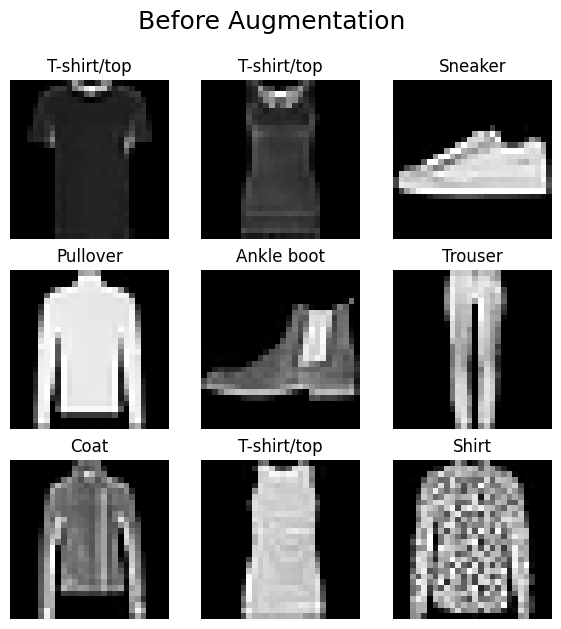

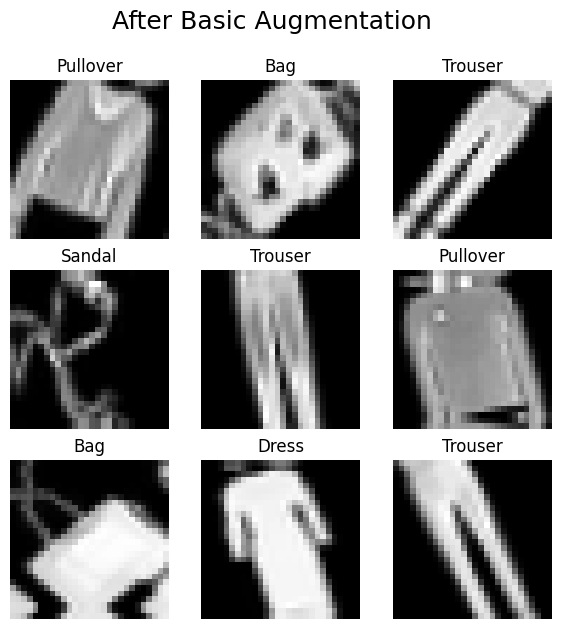

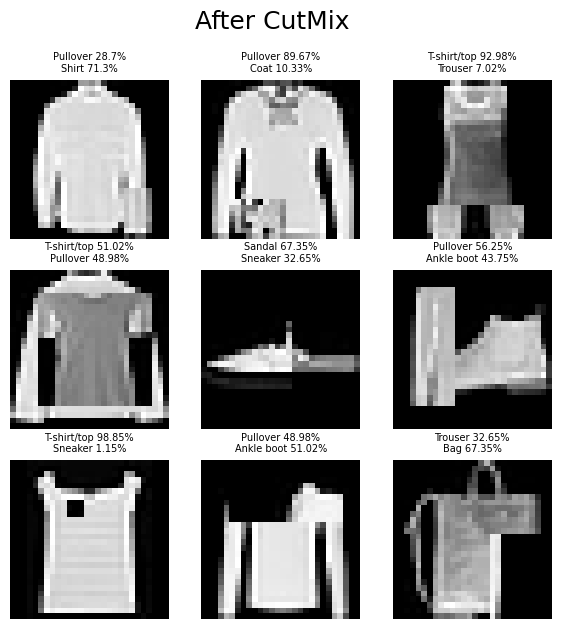

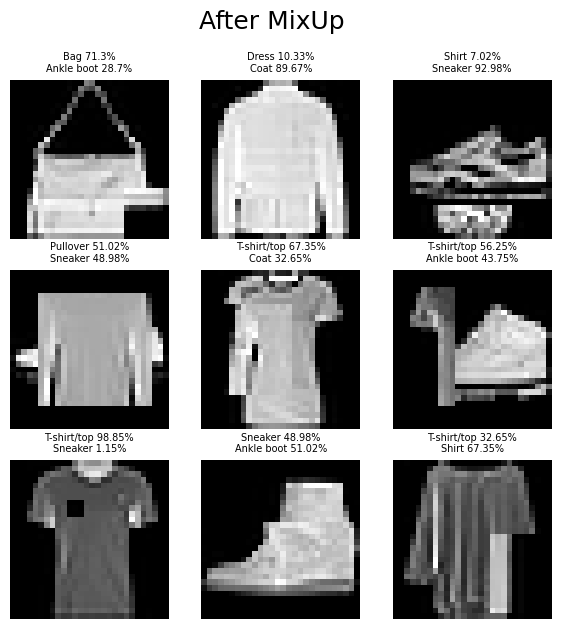

In [7]:

# try basic augmentation
basic_augmentation = initial_pipeline.augment(train_set,'basic')


# prepare training set
train_ds = initial_pipeline.prepare_dataset(dataset=train_set,split='train')
prep_pipeline.visualize_dataset_1(train_ds,title="Before Augmentation")
merge_ds = initial_pipeline.prepare_dataset(dataset=train_set,split='train')
merge_ds = merge_ds.map(prep_pipeline.preprocess_for_model, num_parallel_calls=initial_pipeline.AUTOTUNE)


# visualise basic augmentation
prep_pipeline.visualize_dataset_1(basic_augmentation, title="After Basic Augmentation")


# try cutmix augmentation
cutmix = initial_pipeline.augment(train_ds,'cut')
prep_pipeline.visualize_dataset_2(cutmix, title="After CutMix")

# try mixup augmentation
mixup = initial_pipeline.augment(train_ds,'up')
prep_pipeline.visualize_dataset_2(cutmix, title="After MixUp")


# merge cutmix
cutmix = cutmix.map(prep_pipeline.preprocess_for_model, num_parallel_calls=initial_pipeline.AUTOTUNE)
cutmix = cutmix.concatenate(merge_ds).prefetch(initial_pipeline.AUTOTUNE)

# merge mixup
mixup = mixup.map(prep_pipeline.preprocess_for_model, num_parallel_calls=initial_pipeline.AUTOTUNE)
mixup = mixup.concatenate(merge_ds).prefetch(initial_pipeline.AUTOTUNE)


# merge basic augmentation
basic_augmentation = basic_augmentation.map(prep_pipeline.preprocess_for_model, num_parallel_calls=initial_pipeline.AUTOTUNE)
basic_augmentation = basic_augmentation.concatenate(merge_ds).prefetch(initial_pipeline.AUTOTUNE)


train_ds = train_ds.map(prep_pipeline.preprocess_for_model, num_parallel_calls=initial_pipeline.AUTOTUNE).prefetch(initial_pipeline.AUTOTUNE)

# Model Exploration & Evaluation
We will be exploring different:
- Models
- Optimisation Algorithms
- Loss Functions
- Normalisation Methods
- Regularisation Methods

In general, for each model, we will approach the architecture like this:
1. Input
2. Convolutional
3. Pooling
4. Normalisation
5. Dropout
6. Output

**Pooling Layers**
Pooling layers reduce the dimensions of the hidden layer by combining the outputs of neuron clusters at the previous layer into a single neuron in the next layer. [2](https://www.sciencedirect.com/topics/mathematics/pooling-layer#:~:text=The%20purpose%20of%20the%20pooling,Correction%20(Second%20Edition)%2C%202021)


## Model Regularisation
### Dropout Layers
Dropout layer will be put between dense layers. Dropout layers are important in training CNNs because they prevent overfitting on the training data. If they aren’t present, the first batch of training samples influences the learning in a disproportionately high manner. This, in turn, would prevent the learning of features that appear only in later samples or batches [3](https://www.baeldung.com/cs/ml-relu-dropout-layers#:~:text=4.-,The%20Dropout%20Layer,and%20leaves%20unmodified%20all%20others.)

### L1 & L2 Regularisation
L1 and L2 are the most common types of regularization. These update the general cost function by adding another term known as the regularization term. (Analytics Vidhya, 2018)

Due to the addition of this regularization term, the values of weight matrices decrease because it assumes that a neural network with smaller weight matrices leads to simpler models. Therefore, it will also reduce overfitting to quite an extent. (Analytics Vidhya, 2018)
$$
\text{L1} = Loss + \frac{\lambda}{2m} * \sum||w||
$$
$$
\text{L2} = Loss + \frac{\lambda}{2m} * \sum||w||^2
$$


Analytics Vidhya (2018). An Overview of Regularization Techniques in Deep Learning (with Python code). [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/.

‌



## Baseline Model
We are using a baseline model to compare the difference in performance between frontier CNN Architectures and basic CNN models.

This comparison allows us to make a an informed decision as to whether the performance improvement is worth the exponential increase in computational power and resources required.


### Model Creation

In [8]:
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, CSVLogger

class Model_init:
    def __init__(self):
        self.BATCH_SIZE = 64
        # early stopping
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,min_delta=0.01)
        # reduce learning rate
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
        self.decay = LearningRateScheduler(self.lr_decay) # learning rate decay
        self.callbacks =[self.early_stopping,self.reduce_lr,self.decay] # list of callbacks
        
    def compile(self,input1,output):
        # instantiate model
        model = Model(inputs=input1, outputs=output)
        
        # compile model
        model.compile(
            optimizer=keras.optimizers.Adagrad(learning_rate=0.001,decay=1e-6),
            loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.3),
            metrics=["categorical_accuracy"])
        return model

    def visualise(self,model,name):
        # summarise model
        model.summary()
        # visualise model
        font = ImageFont.truetype("arial.ttf", 20)
        display(visualkeras.layered_view(model,to_file=f'../part_a/images/models/{name}.png',legend=True,font=font,scale_xy=7,scale_z=1,max_xy=1000))
    def lr_decay(self,epoch): # learning rate decay
            initial_lrate = 0.001
            drop = 0.5
            epochs_drop = 30
            lrate = initial_lrate * math.pow(drop,  
                math.floor((1+epoch)/epochs_drop))
            print('Learning rate: ', lrate)
            return lrate

class PlotResults:
    def __init__(self,models,aug_methods):
        self.models = models
        self.aug_methods = aug_methods

    def plot(self):
        for mod, aug in zip(self.models,self.aug_methods):
            plt.figure(figsize=(10,5))
            plt.subplot(1, 2, 1)
            plt.plot(mod.history['loss'])
            plt.plot(mod.history['val_loss'])
            plt.title('Loss for '+ aug)
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right')
            plt.subplot(1, 2, 2)
            plt.plot(mod.history['categorical_accuracy'])
            plt.plot(mod.history['val_categorical_accuracy'])
            plt.title('Categorical Accuracy for '+  aug)
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='lower right')
            plt.show()
            


In [ ]:
#functional api used instead of sequential api
class Baseline(Model_init):
    def __init__(self):
        super().__init__()
        self.Input = Input
        self.Rescaling = Rescaling
        self.Conv2D = Conv2D
        self.AveragePooling2D = AveragePooling2D
        self.Flatten = Flatten
        self.Dense = Dense
        self.MaxPooling2D = MaxPooling2D
        self.BatchNormalization = BatchNormalization



    # baseline model architecture
    def architecture(self):
        input1 = self.Input((28, 28, 1))
        x = self.Rescaling(1/255)(input1) #normalise input
        x = self.Conv2D(filters=6, kernel_size=(3, 3), activation='relu',padding="same")(x)
        x = self.MaxPooling2D(padding="same")(x)
        x = self.Flatten()(x)
        x = self.Dense(units=120, activation='relu')(x)
        output = self.Dense(units=10, activation ='softmax')(x)
        return self.compile(input1,output)

    

### Model Initialisation

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 6)         60        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1176)              0         
                                                                 
 dense_2 (Dense)             (None, 120)               141240    
                                                           

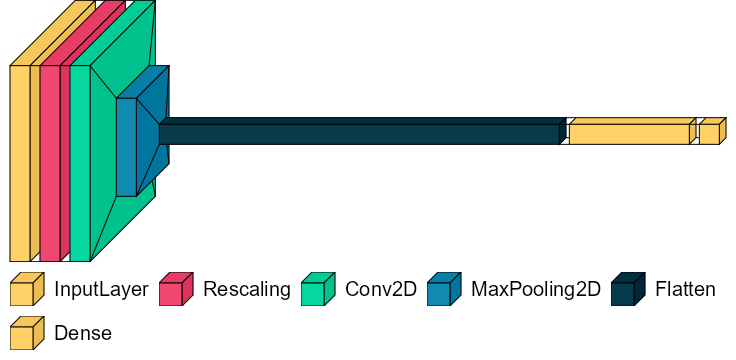

In [20]:
# experimenting with different data augmentation methods
baseline = Baseline()
baseline_model = baseline.architecture()
baseline.visualise(baseline_model,'baseline')

### Model Training

### Vanilla Model without Augmentation


In [34]:
# vanilla model without any augmentation
baseline_vanilla_model = baseline_model.fit(train_ds, epochs=100, verbose=1, validation_data=valid_ds,callbacks=[baseline.callbacks, CSVLogger('../part_a/results/baseline/baseline_vanilla.csv', append=True, separator=',')])
baseline_model.evaluate(test_ds)
baseline_model.save('../part_a/models/baseline/baseline_vanilla_model.h5')
tf.keras.backend.clear_session()

Learning rate:  0.001
Epoch 1/100
391/391 [==============================] - 4s 9ms/step - loss: 1.5780 - categorical_accuracy: 0.7618 - val_loss: 1.5676 - val_categorical_accuracy: 0.7695 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
391/391 [==============================] - 3s 8ms/step - loss: 1.5638 - categorical_accuracy: 0.7714 - val_loss: 1.5554 - val_categorical_accuracy: 0.7758 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
391/391 [==============================] - 3s 8ms/step - loss: 1.5526 - categorical_accuracy: 0.7781 - val_loss: 1.5454 - val_categorical_accuracy: 0.7861 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
391/391 [==============================] - 3s 7ms/step - loss: 1.5433 - categorical_accuracy: 0.7840 - val_loss: 1.5370 - val_categorical_accuracy: 0.7925 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
391/391 [==============================] - 3s 7ms/step - loss: 1.5354 - categorical_accuracy: 0.7895 - val_loss: 1.5295 - val_categorical_accuracy: 0.7938 - l

### Basic Data Augmentation Model

In [37]:
# #basic data augmentation
baseline_model = Baseline()
baseline_model = baseline_model.architecture()
baseline_basic_model = baseline_model.fit(basic_augmentation, epochs=100, verbose=1, validation_data=valid_ds,callbacks=
[baseline.callbacks, CSVLogger('../part_a/results/baseline/baseline_basic.csv', append=True, separator=',')])
baseline_model.evaluate(test_ds)
baseline_model.save('../part_a/models/baseline/baseline_basic_model.h5')
tf.keras.backend.clear_session()

Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 50s 63ms/step - loss: 2.0627 - categorical_accuracy: 0.4041 - val_loss: 1.7708 - val_categorical_accuracy: 0.6343 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 44s 56ms/step - loss: 1.8398 - categorical_accuracy: 0.5451 - val_loss: 1.6705 - val_categorical_accuracy: 0.6923 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 43s 55ms/step - loss: 1.7779 - categorical_accuracy: 0.5953 - val_loss: 1.6340 - val_categorical_accuracy: 0.7175 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 44s 56ms/step - loss: 1.7446 - categorical_accuracy: 0.6259 - val_loss: 1.6114 - val_categorical_accuracy: 0.7351 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 45s 57ms/step - loss: 1.7223 - categorical_accuracy: 0.6442 - val_loss: 1.5943 - val_categorical_accuracy: 

### CutMix Augmentation Model

In [28]:
# CutMix model augmentation
baseline_model = Baseline()
baseline_model = baseline_model.architecture()
baseline_cutmix_model = baseline_model.fit(cutmix, epochs=100, verbose=1, validation_data=valid_ds,
callbacks=[baseline.callbacks, CSVLogger('../part_a/results/baseline/baseline_cutmix.csv', append=True, separator=',')])
baseline_model.evaluate(test_ds)
baseline_model.save('../part_a/models/baseline/baseline_cutmix_model.h5')
tf.keras.backend.clear_session()

Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 7s 8ms/step - loss: 2.1179 - categorical_accuracy: 0.3816 - val_loss: 1.8517 - val_categorical_accuracy: 0.6041 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 6s 8ms/step - loss: 1.8928 - categorical_accuracy: 0.5401 - val_loss: 1.6952 - val_categorical_accuracy: 0.6865 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 6s 7ms/step - loss: 1.8250 - categorical_accuracy: 0.5921 - val_loss: 1.6375 - val_categorical_accuracy: 0.7354 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 6s 7ms/step - loss: 1.7909 - categorical_accuracy: 0.6197 - val_loss: 1.6036 - val_categorical_accuracy: 0.7598 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 6s 7ms/step - loss: 1.7701 - categorical_accuracy: 0.6362 - val_loss: 1.5803 - val_categorical_accuracy: 0.7738 - l

### MixUp Augmentation Model

In [29]:
# MixUp model augmentation
baseline_model = Baseline()
baseline_model = baseline_model.architecture()
baseline_mixup_model = baseline_model.fit(mixup, epochs=100, verbose=1, validation_data=valid_ds,
callbacks=[baseline.callbacks, CSVLogger('../part_a/results/baseline/baseline_mixup.csv', append=True, separator=',')])
baseline_model.evaluate(test_ds)
baseline_model.save('../part_a/models/baseline/baseline_mixup_model.h5')
tf.keras.backend.clear_session()

Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 7s 8ms/step - loss: 1.9905 - categorical_accuracy: 0.4677 - val_loss: 1.7235 - val_categorical_accuracy: 0.6525 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 6s 7ms/step - loss: 1.7716 - categorical_accuracy: 0.6591 - val_loss: 1.6267 - val_categorical_accuracy: 0.7269 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 6s 7ms/step - loss: 1.7195 - categorical_accuracy: 0.7014 - val_loss: 1.5889 - val_categorical_accuracy: 0.7531 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 6s 7ms/step - loss: 1.6917 - categorical_accuracy: 0.7258 - val_loss: 1.5654 - val_categorical_accuracy: 0.7693 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 5s 7ms/step - loss: 1.6741 - categorical_accuracy: 0.7385 - val_loss: 1.5478 - val_categorical_accuracy: 0.7854 - l


### Model Analysis
For our baseline neural network, we can observe that the average performance of a dumb baseline model on the `fashion_mnist` dataset is around 80%. This is a very average performance, and we can see that the model is not learning anything from the data. Hence, we will be implementing a more complex model to see if we can improve the performance.


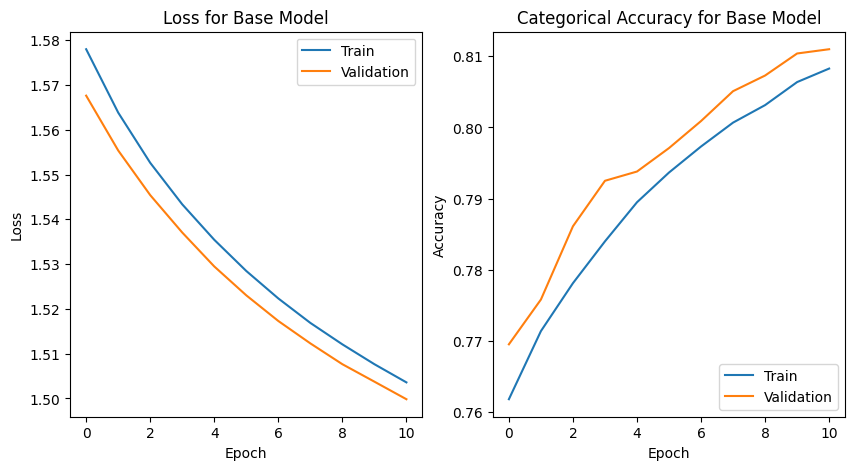

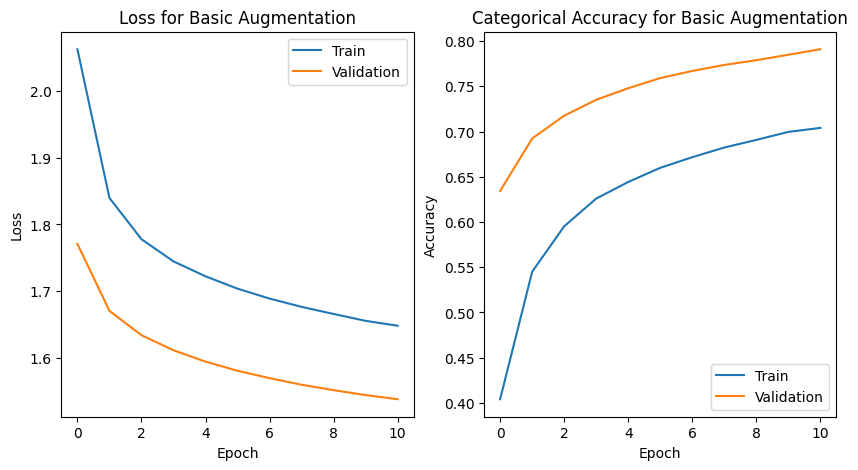

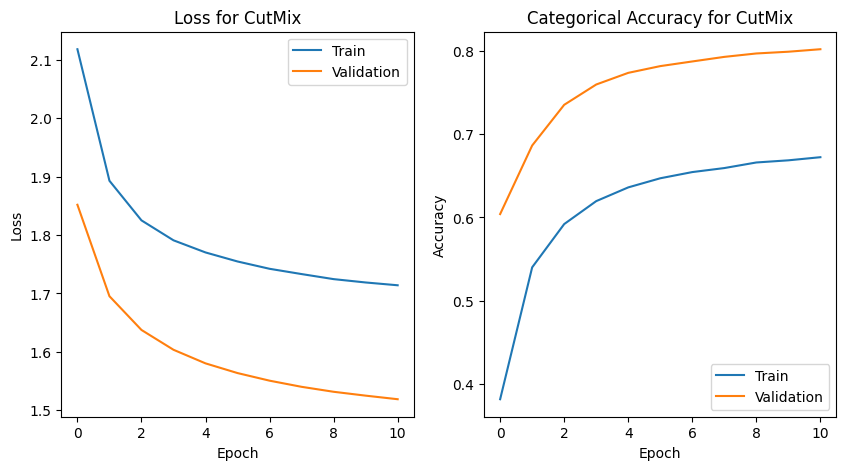

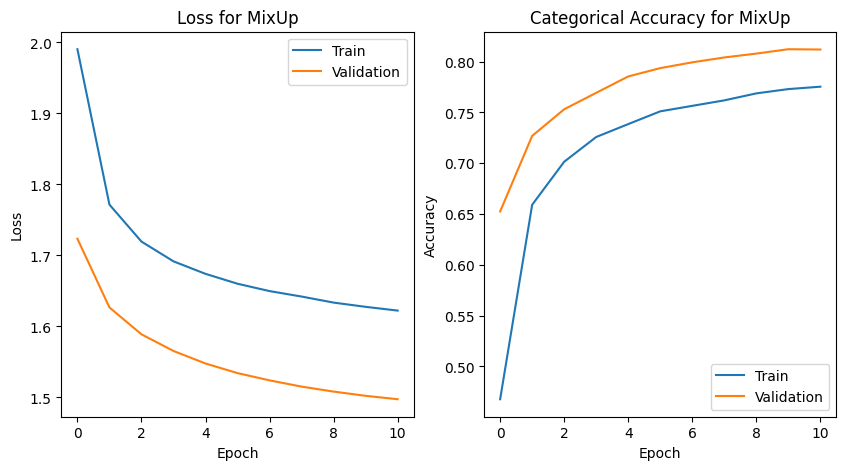

In [38]:


plot = PlotResults([baseline_vanilla_model,baseline_basic_model,baseline_cutmix_model,baseline_mixup_model],['Base Model','Basic Augmentation', 'CutMix','MixUp'])
plot.plot()


## LeNet-5
1. Convolution  #1 Input = 28x28x1  | Output = 28x28x6 `conv2d`
2. SubSampling  #1 Input = 28x28x6  | Output = 14x14x6. SubSampling is simply Average Pooling, so we use `avg_pool`
3. BatchNorm    #1 Input = 13x13x6  | Output = 13x13x6. `BatchNormalization`
4. Convolution  #2 Input = 14x14x6  | Output = 10x10x16 `conv2d`
5. SubSampling  #2 Input = 10x10x16 | Output = 5x5x16 `avg_pool`
6. BatchNorm    #2 Input = 13x13x6  | Output = 13x13x6. `BatchNormalization`
7. Fully Connected #1. Input = 5x5x16. Output = 120
8. Fully Connected #2. Input = 120. Output = 84
9. Output

Credit: [5](https://www.analyticsvidhya.com/blog/2021/07/understanding-sequential-vs-functional-api-in-keras/)

### History
What is LeNet-5?
In general, LeNet refers to LeNet-5 and is a simple convolutional neural network. Convolutional neural networks are a kind of feed-forward neural network whose artificial neurons can respond to a part of the surrounding cells in the coverage range and perform well in large-scale image processing. [6](https://en.wikipedia.org/wiki/LeNet)


We use the Functional API over Sequential API.
The reason why we use the Functional API is because:
1. The functional API offers more flexibility and control over the layers than the sequential API.
2. It can be used to predict multiple outputs(i.e output layers) with multiple inputs(i.e input layers))


We will also be using `CategoricalCrossentropy` as opposed to `SparseCategoricalCrossentropy` as the documentation states:

> "We expect labels to be provided in a `one_hot` representation. If
    you want to provide labels as integers, please use
    `SparseCategoricalCrossentropy` loss. "

![Lesnet Architecture](images/lesnet.png)


This is a visual representation of what the LeNet-5 Model looks like.
> Credit: LeCun et al., 1998

In [39]:
#lenet-5 model with augmentation

# data_augmentation = keras.Sequential(
#     [
#         keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
#         keras.layers.experimental.preprocessing.RandomTranslation([-0.2,0.2],[-0.2,0.2]),
#         keras.layers.experimental.preprocessing.RandomZoom(-0.2,0.2),
#         layers.RandomBrightness([-0.2,0.2]),
#
#
#     ]
# )
# I wanted to implement this Sequential model into the Functional API, but due to a bug from Tensorflow, I decided against it and instead placed the Data Augmentation into the Data Pipeline


### Model Creation 

We create a normal model that we will be using for:
- Basic model
- CutMix model
- MixUp model

1. We have used the functional API instead of the sequential API, since it is more flexible and we can build more complex models.
2. The Rescaling layer is used to normalise the input. This is not part of the original LeNet-5 architecture, but it is a common practice when working with images.
3. The Batch Normalisation layer is not part of the original LeNet-5 architecture, but it is a common practice when training deep neural networks.
4. The Dense layer has a Leaky ReLU activation function. This is not part of the original LeNet-5 architecture, but it is a common practice when training deep neural networks.
5. The Dense layer has a softmax activation function, since it is a multiclass classification problem.
6. The model is compiled with the Adam optimizer, the Categorical Crossentropy loss function and the Categorical Accuracy metric.
7. The model is visualised using the Visualkeras library. 

For the basic data augmentation:
1. We are taking the input image and applying a horizontal.
4. We are then applying random rotation to it.
6. We are then applying random zoom to it.
5. We are then resizing the image to 28x28



In [40]:
from keras.layers import Rescaling, BatchNormalization
from functools import partial


#functional api used instead of sequential api
class Lenet(Model_init):
    def __init__(self):
        super().__init__()
        self.Input = Input
        self.Rescaling = Rescaling
        self.Conv2D = Conv2D
        self.AveragePooling2D = AveragePooling2D
        self.Flatten = Flatten
        self.Dense = Dense
        self.BatchNormalization = BatchNormalization
        

    # lenet model architecture
    def architecture(self):
        input1 = self.Input((28, 28, 1))
        x = self.Rescaling(1/255)(input1) #normalise input
        x = self.Conv2D(filters=6, kernel_size=(3, 3), activation='relu',padding="same")(x)
        x = self.AveragePooling2D(padding="same")(x)
        x = self.BatchNormalization()(x) #batch norm (not lenet-5)
        x = self.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',padding="same")(x)
        x = self.AveragePooling2D(padding="same")(x)
        x = self.Flatten()(x)
        x = self.Dense(units=120, activation='relu')(x)
        x = self.Dense(units=84, activation='relu')(x)
        x = self.BatchNormalization()(x) #batch norm (not lenet-5)
        output = self.Dense(units=10, activation ='softmax')(x) #think abt changing it back to leaky relu?
        return self.compile(input1,output)

### Model Initialisation

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 6)        24        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        880   

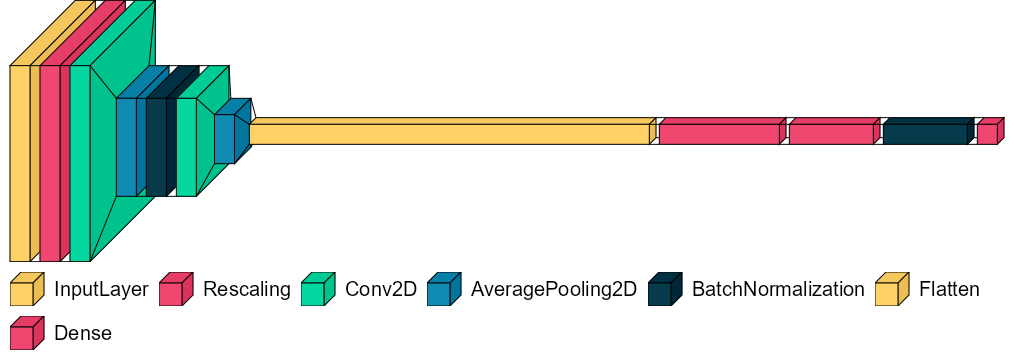

In [41]:
# experimenting with different data augmentation methods
lenet = Lenet()
lenet_model = lenet.architecture()
lenet.visualise(lenet_model,'lenet')


In [42]:
tf.keras.backend.clear_session()


### Model Training

#### Vanilla Model
We are now training the model without any data augmentation for 100 epochs. The reason for doing this is to evaluate whether there is any performance gain from augmenting the train data to reduce overfitting.

In [43]:
# vanilla model without any augmentation
lenet = Lenet()
lenet_model = lenet.architecture()
lenet_vanilla_model = lenet_model.fit(train_ds, epochs=100, verbose=1, validation_data=valid_ds,callbacks=
[lenet.callbacks, CSVLogger('../part_a/results/lenet/lenet_vanilla.csv', append=True, separator=',')])
lenet_model.evaluate(test_ds)
lenet_model.save('../part_a/models/lenet/vanilla_model.h5')
tf.keras.backend.clear_session()


Learning rate:  0.001
Epoch 1/100
391/391 [==============================] - 4s 9ms/step - loss: 1.6858 - categorical_accuracy: 0.6754 - val_loss: 1.8618 - val_categorical_accuracy: 0.6535 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
391/391 [==============================] - 3s 8ms/step - loss: 1.5377 - categorical_accuracy: 0.7737 - val_loss: 1.5127 - val_categorical_accuracy: 0.7891 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
391/391 [==============================] - 4s 9ms/step - loss: 1.5021 - categorical_accuracy: 0.8001 - val_loss: 1.4874 - val_categorical_accuracy: 0.8091 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
391/391 [==============================] - 4s 10ms/step - loss: 1.4814 - categorical_accuracy: 0.8151 - val_loss: 1.4711 - val_categorical_accuracy: 0.8183 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
391/391 [==============================] - 4s 10ms/step - loss: 1.4676 - categorical_accuracy: 0.8225 - val_loss: 1.4605 - val_categorical_accuracy: 0.8283 -

#### Basic Augmentation Model
I initially put the data augmentation into the model building, but I realised that that it would make the model training too slow, as the model would have to continously repeat the data augmentation.

Hence, I moved the data augmentation before the model training, and added it as a new dataset `basic_augmentation`, the same way I did with the other augmentation methods as you will see below.

In [44]:

# # model with basic augmentation (flipping,rotation, zoom, etc...)
lenet = Lenet()
lenet_model = lenet.architecture()
lenet_basic_model = lenet_model.fit(basic_augmentation, epochs=10, verbose=1, validation_data=valid_ds,callbacks=
[lenet.callbacks, CSVLogger('../part_a/results/lenet/lenet_basic.csv', append=True, separator=',')])
lenet_model.evaluate(test_ds)
lenet_model.save('../part_a/models/lenet/lenet_basic_model.h5')
tf.keras.backend.clear_session()



Learning rate:  0.001
Epoch 1/10
782/782 [==============================] - 70s 88ms/step - loss: 1.7624 - categorical_accuracy: 0.6099 - val_loss: 1.5526 - val_categorical_accuracy: 0.7563 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
782/782 [==============================] - 76s 97ms/step - loss: 1.6353 - categorical_accuracy: 0.6979 - val_loss: 1.5191 - val_categorical_accuracy: 0.7785 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
782/782 [==============================] - 78s 100ms/step - loss: 1.5989 - categorical_accuracy: 0.7235 - val_loss: 1.4987 - val_categorical_accuracy: 0.7950 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
782/782 [==============================] - 75s 95ms/step - loss: 1.5769 - categorical_accuracy: 0.7386 - val_loss: 1.4848 - val_categorical_accuracy: 0.8023 - lr: 0.0010
Learning rate:  0.001
Epoch 5/10
782/782 [==============================] - 75s 95ms/step - loss: 1.5616 - categorical_accuracy: 0.7506 - val_loss: 1.4740 - val_categorical_accuracy: 0.81

#### CutMix Augmentation Model


In [45]:
lenet = Lenet()
lenet_model = lenet.architecture()
lenet_cutmix_model = lenet_model.fit(cutmix, epochs=100, verbose=1, validation_data=valid_ds,callbacks=
[lenet.callbacks, CSVLogger('../part_a/results/lenet/lenet_cutmix.csv', append=True, separator=',')])
lenet_model.evaluate(test_ds)
lenet_model.save('../part_a/models/lenet/lenet_cutmix_model.h5')
tf.keras.backend.clear_session()


Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 6s 7ms/step - loss: 1.8479 - categorical_accuracy: 0.5703 - val_loss: 1.5379 - val_categorical_accuracy: 0.7729 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 5s 6ms/step - loss: 1.7347 - categorical_accuracy: 0.6492 - val_loss: 1.4979 - val_categorical_accuracy: 0.7968 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 5s 6ms/step - loss: 1.7062 - categorical_accuracy: 0.6701 - val_loss: 1.4772 - val_categorical_accuracy: 0.8104 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 5s 6ms/step - loss: 1.6887 - categorical_accuracy: 0.6822 - val_loss: 1.4638 - val_categorical_accuracy: 0.8190 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 5s 6ms/step - loss: 1.6779 - categorical_accuracy: 0.6914 - val_loss: 1.4541 - val_categorical_accuracy: 0.8255 - l

#### MixUp Augmentation Model

In [46]:
lenet = Lenet()
lenet_model = lenet.architecture()
lenet_mixup_model = lenet_model.fit(mixup, epochs=100, verbose=1, validation_data=valid_ds,callbacks=
[lenet.callbacks, CSVLogger('../part_a/results/lenet/lenet_mixup.csv', append=True, separator=',')])
lenet_model.evaluate(test_ds)
lenet_model.save('../part_a/models/lenet/lenet_mixup_model.h5')
tf.keras.backend.clear_session()



Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 7s 8ms/step - loss: 1.7702 - categorical_accuracy: 0.6633 - val_loss: 1.5312 - val_categorical_accuracy: 0.7861 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 7s 8ms/step - loss: 1.6553 - categorical_accuracy: 0.7462 - val_loss: 1.4895 - val_categorical_accuracy: 0.8097 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 6s 8ms/step - loss: 1.6276 - categorical_accuracy: 0.7647 - val_loss: 1.4710 - val_categorical_accuracy: 0.8174 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 6s 7ms/step - loss: 1.6124 - categorical_accuracy: 0.7743 - val_loss: 1.4567 - val_categorical_accuracy: 0.8271 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 5s 6ms/step - loss: 1.6020 - categorical_accuracy: 0.7817 - val_loss: 1.4469 - val_categorical_accuracy: 0.8312 - l

We can observe the breakdown of our LeNet Model.

The input layer is connected to 2 sets of Conv2D + AveragePooling2D layers, which is then flattened and then connected into 3 Dense layers to result in the output layer

### Model Analysis & Result Visualisation

We plot the Model Loss and Model Accuracy of training and test against each other to identify where the model overfits.

After which, we can apply Early Stopping from `keras.callbacks.EarlyStopping` to stop the model to prevent it from overfitting.

After stopping the model from overfitting, we then save the model with a Checkpoint using `keras.callbacks.ModelCheckpoint`

We will implement this after the baseline model, as we have observed the effects of overfitting in `basic_augmentation_model`.

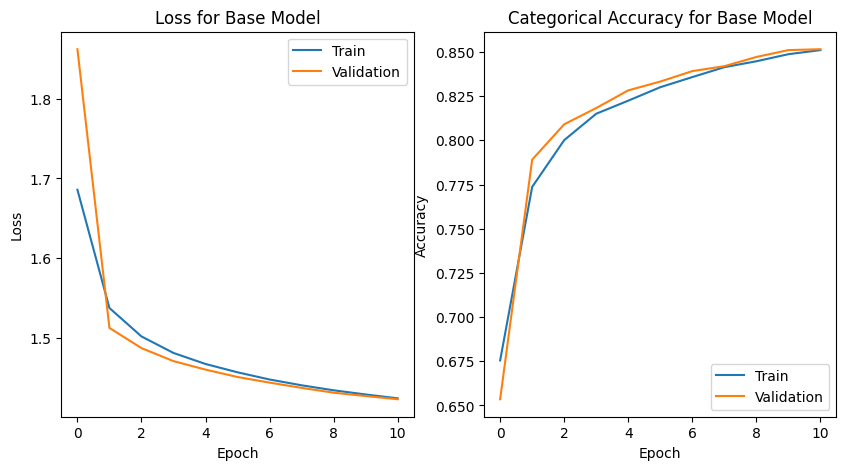

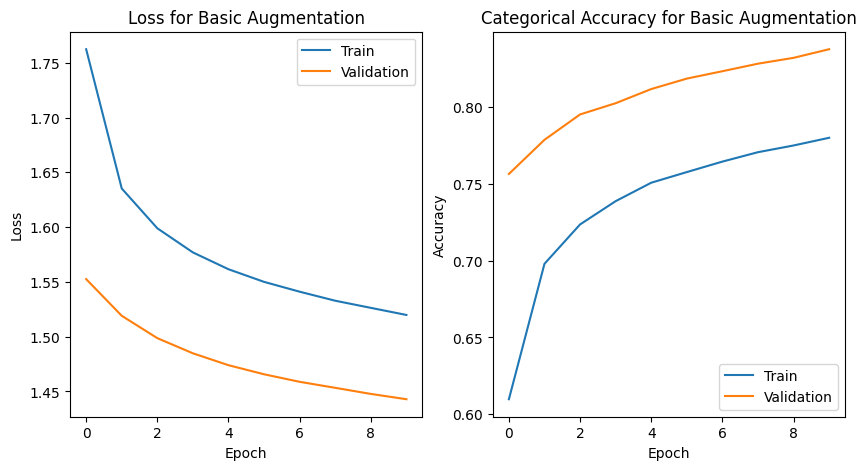

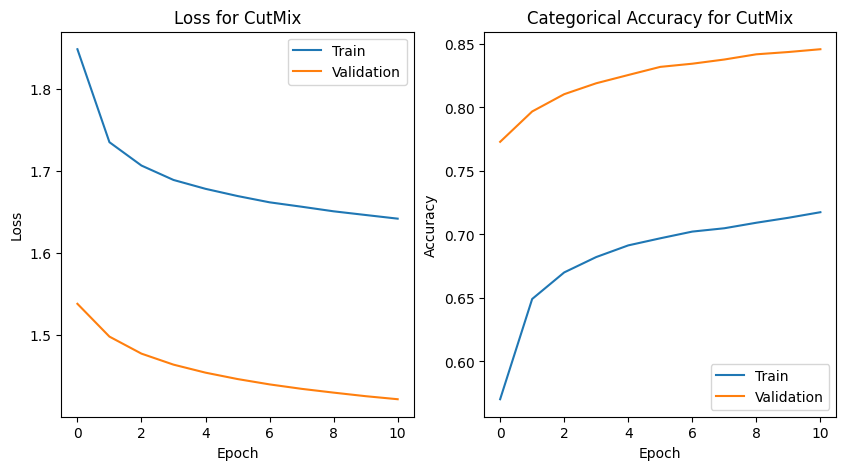

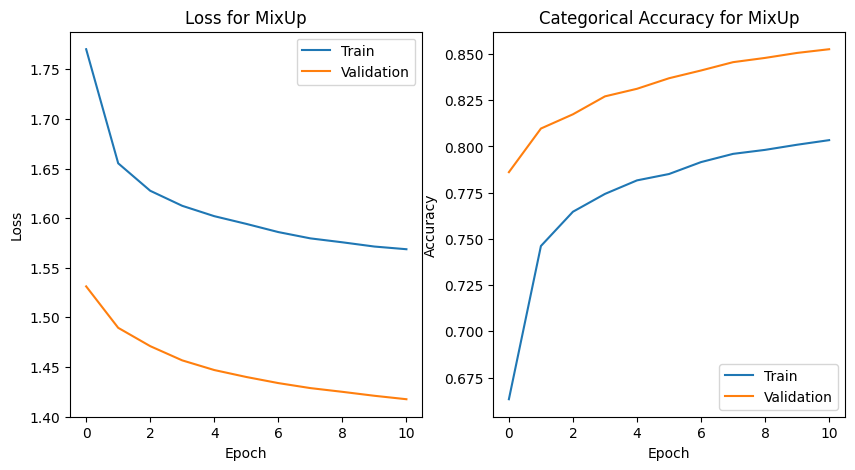

In [47]:
plot = PlotResults([lenet_vanilla_model,lenet_basic_model,lenet_cutmix_model,lenet_mixup_model],['Base Model','Basic Augmentation', 'CutMix','MixUp'])
plot.plot()

In [48]:
# plot_model(model, show_shapes=True,dpi=150,to_file='../part_a/images/baseline_workflow.png')

## AlexNet
[Credit](https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98)

### History
AlexNet is the name of a convolutional neural network (CNN) architecture, designed by Alex Krizhevsky in collaboration with Ilya Sutskever and Geoffrey Hinton, who was Krizhevsky's Ph.D. advisor. (Wikipedia Contributors, 2019)

AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on September 30, 2012. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up. (Wikipedia Contributors, 2019)

The original paper's primary result was that the depth of the model was essential for its high performance, which was computationally expensive, but made feasible due to the utilization of graphics processing units (GPUs) during training. (Wikipedia Contributors, 2019)

Wikipedia Contributors (2019). AlexNet. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/AlexNet.


### Model Creation

In [7]:
# credit https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

from keras.layers import Rescaling, BatchNormalization
from functools import partial


#functional api used instead of sequential api
class AlexNet(Model_init):
    def __init__(self):
        super().__init__()
        self.Input = Input
        self.Rescaling = Rescaling
        self.Conv2D = Conv2D
        self.AveragePooling2D = AveragePooling2D
        self.MaxPooling2D = MaxPooling2D
        self.Flatten = Flatten
        self.Dense = Dense
        self.BatchNormalization = BatchNormalization
        self.Dropout = Dropout
        

    # lenet model architecture
    def architecture(self):
        input1 = self.Input((28, 28, 1))
        x = self.Rescaling(1/255)(input1) #normalise input
        x = self.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu')(x)
        x = self.BatchNormalization()(x) 
        x = self.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
        x = self.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu',padding="same")(x)
        x = self.BatchNormalization()(x)
        x = self.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
        x = self.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation='relu',padding="same")(x)
        x = self.BatchNormalization()(x)
        x = self.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation='relu',padding="same")(x)
        x = self.BatchNormalization()(x)
        x = self.Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation='relu',padding="same")(x)
        x = self.BatchNormalization()(x)
        x = self.MaxPooling2D(pool_size=(1,1), strides=(2,2))(x)
        x = self.Flatten()(x)
        x = self.Dense(units=4096, activation ='relu')(x)
        x = self.Dropout(0.5)(x)
        x = self.Dense(units=4096, activation ='relu')(x)
        x = self.Dropout(0.5)(x)
        output = self.Dense(units=10, activation='softmax')(x)
        return self.compile(input1,output)
        

### Model Initialisation

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 96)         384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 256)         6146

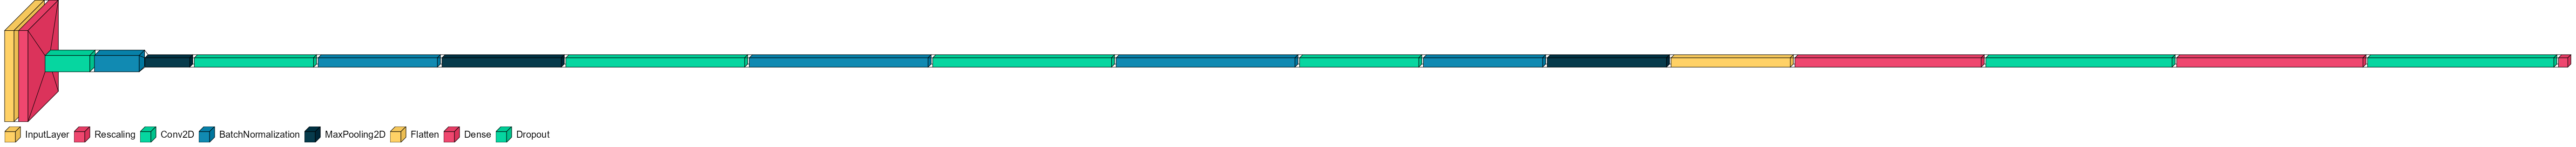

In [8]:
alexnet = AlexNet()
alexnet_model = alexnet.architecture()
alexnet.visualise(alexnet_model,'alexnet')


### Model Training

#### Vanilla Model

In [9]:
alexnet = AlexNet()
alexnet_model = alexnet.architecture()
alexnet_vanilla_model = alexnet_model.fit(train_ds, epochs=100, verbose=1, validation_data=valid_ds,callbacks=
[alexnet.callbacks, CSVLogger('../part_a/results/alexnet/alexnet_vanilla.csv', append=True, separator=',')])
alexnet_model.evaluate(test_ds)
alexnet_model.save('../part_a/models/alexnet/alexnet_vanilla_model.h5')
tf.keras.backend.clear_session()

Learning rate:  0.001
Epoch 1/100
391/391 [==============================] - 17s 27ms/step - loss: 1.7577 - categorical_accuracy: 0.6244 - val_loss: 2.1609 - val_categorical_accuracy: 0.2108 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
391/391 [==============================] - 10s 25ms/step - loss: 1.5380 - categorical_accuracy: 0.7747 - val_loss: 1.4591 - val_categorical_accuracy: 0.8064 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
391/391 [==============================] - 10s 24ms/step - loss: 1.4942 - categorical_accuracy: 0.8052 - val_loss: 1.4372 - val_categorical_accuracy: 0.8255 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
391/391 [==============================] - 9s 24ms/step - loss: 1.4687 - categorical_accuracy: 0.8234 - val_loss: 1.4217 - val_categorical_accuracy: 0.8369 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
391/391 [==============================] - 9s 24ms/step - loss: 1.4526 - categorical_accuracy: 0.8344 - val_loss: 1.4136 - val_categorical_accuracy: 0.

#### Basic Augmentation Model

In [10]:
# alexnet = AlexNet()
# alexnet_model = alexnet.architecture()
# alexnet_basic_model = alexnet_model.fit(basic_augmentation, epochs=10, verbose=1, validation_data=valid_ds,callbacks=
# [alexnet.callbacks, CSVLogger('../part_a/results/alexnet/alexnet_basic.csv', append=True, separator=',')])
# alexnet_model.evaluate(test_ds)
# alexnet_model.save('../part_a/models/alexnet/alexnet_basic_model.h5')
# tf.keras.backend.clear_session()

Learning rate:  0.001
Epoch 1/10
625/782 [======================>.......] - ETA: 33s - loss: 1.8362 - categorical_accuracy: 0.5500

KeyboardInterrupt: 

#### CutMix Augmentation Model

In [11]:
alexnet = AlexNet()
alexnet_model = alexnet.architecture()
alexnet_cutmix_model = alexnet_model.fit(cutmix, epochs=100, verbose=1, validation_data=valid_ds,callbacks=
[alexnet.callbacks,CSVLogger('../part_a/models/alexnet/alexnet_cutmix_model.csv')])
alexnet_model.evaluate(test_ds)
alexnet_model.save('../part_a/models/alexnet/alexnet_cutmix_model.h5')
tf.keras.backend.clear_session()

Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 40s 47ms/step - loss: 1.8791 - categorical_accuracy: 0.5318 - val_loss: 1.4931 - val_categorical_accuracy: 0.7804 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 19s 24ms/step - loss: 1.7561 - categorical_accuracy: 0.6471 - val_loss: 1.4474 - val_categorical_accuracy: 0.8183 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 19s 24ms/step - loss: 1.7226 - categorical_accuracy: 0.6732 - val_loss: 1.4311 - val_categorical_accuracy: 0.8281 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 18s 24ms/step - loss: 1.7010 - categorical_accuracy: 0.6890 - val_loss: 1.4153 - val_categorical_accuracy: 0.8377 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 18s 23ms/step - loss: 1.6870 - categorical_accuracy: 0.6961 - val_loss: 1.4082 - val_categorical_accuracy: 

#### MixUp Augmentation Model

In [12]:
alexnet = AlexNet()
alexnet_model = alexnet.architecture()
alexnet_mixup_model = alexnet_model.fit(mixup, epochs=100, verbose=1, validation_data=valid_ds,callbacks=
[alexnet.callbacks,CSVLogger('../part_a/models/alexnet/alexnet_mixup_model.csv')])
alexnet_model.evaluate(test_ds)
alexnet_model.save('../part_a/models/alexnet/alexnet_mixup_model.h5')
tf.keras.backend.clear_session()

Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 19s 23ms/step - loss: 1.7940 - categorical_accuracy: 0.6223 - val_loss: 1.4817 - val_categorical_accuracy: 0.7909 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 18s 22ms/step - loss: 1.6559 - categorical_accuracy: 0.7490 - val_loss: 1.4351 - val_categorical_accuracy: 0.8227 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 18s 22ms/step - loss: 1.6239 - categorical_accuracy: 0.7738 - val_loss: 1.4173 - val_categorical_accuracy: 0.8373 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 18s 23ms/step - loss: 1.6041 - categorical_accuracy: 0.7865 - val_loss: 1.4065 - val_categorical_accuracy: 0.8437 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 18s 23ms/step - loss: 1.5888 - categorical_accuracy: 0.7968 - val_loss: 1.3978 - val_categorical_accuracy: 


### Model Analysis

For AlexNet, we see that the average performance of each model regardless of its data used roughly averages around 86% validation accuracy. This is not improvement from the LeNet model, which also had an average of 80-85% validation accuracy. In fact, the validation accuracy of the AlexNet model is slightly worse than the LeNet model.

This is because AlexNet is a more complex model than LeNet, and hence it requires more data to train on. This is why we see that the AlexNet model overfits more than the LeNet model. This is also why we see that the AlexNet model performs worse than the LeNet model.

Additionally, the use of dropout layers in the AlexNet model also helps to reduce overfitting, but it also reduces the performance of the model. This is because dropout layers randomly drop neurons during training, which means that the model is not able to learn as much as it would without dropout layers. Hence, the model is not able to perform as well as it would without dropout layers. As is with all forms of regularisation, there is a trade-off between performance and overfitting.



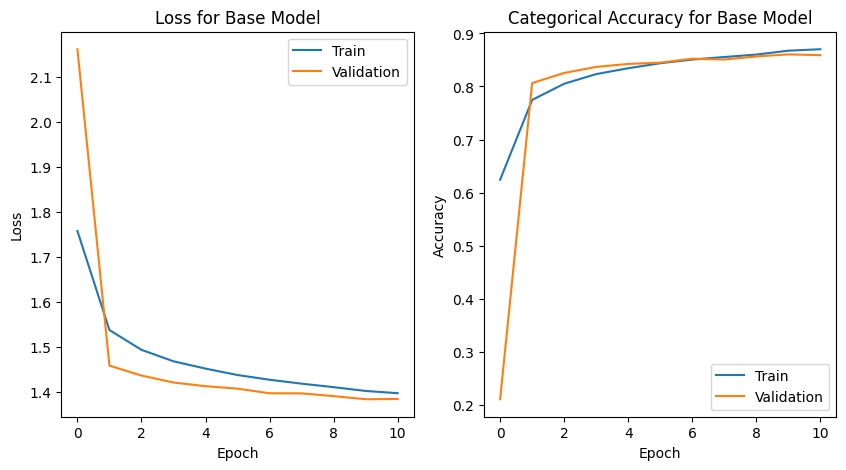

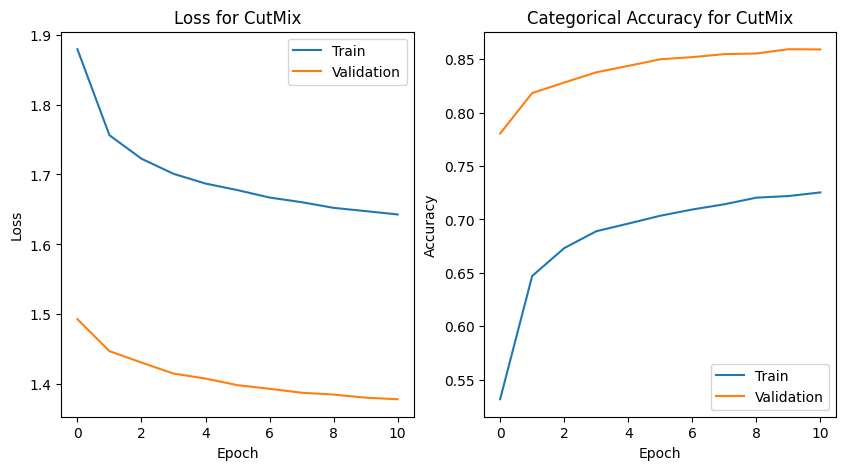

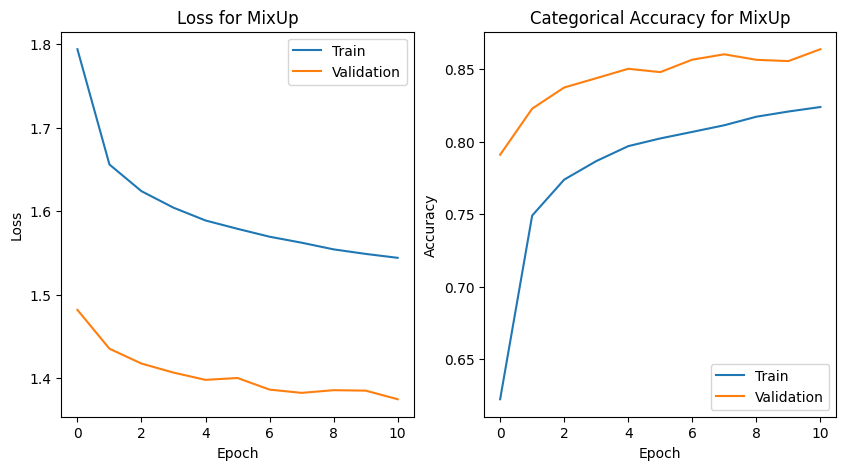

In [13]:
plot = PlotResults([alexnet_vanilla_model,alexnet_cutmix_model,alexnet_mixup_model],['Base Model', 'CutMix','MixUp'])
plot.plot()

## ResNet34

[Credit](https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/)

### History
Following the first CNN-based architecture (AlexNet), which won the ImageNet 2012 competition, each subsequent winning architecture employs more layers in a deep neural network to reduce error rates. 

This works for fewer layers, but as the number of layers increases, we encounter a common problem in deep learning known as the Vanishing/Exploding gradient. 

As a result, the gradient becomes 0 or too large. As the number of layers increases, so does the training and testing error rate.

This architecture introduced the concept of Residual Blocks to solve the problem of the vanishing/exploding gradient. In this network, we employ a technique known as skip connections. 

The skip connection connects layer activations to subsequent layers by skipping some layers in between. This results in the formation of a residual block. These residual blocks are stacked together to form renets.

Instead of layers learning the underlying mapping, this network allows the network to fit the residual mapping.

Let's take a look at the CNN Architecture

![Resnet Architecture](images/resnet_arch.png)

### Model Creation

In [17]:
# credit https://github.com/safwankdb/ResNet34-TF2/blob/master/model.py
# modified implementation of resnet34 model referencing the above github repo

from keras.activations import relu
from keras import layers as Layers
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator



class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = Activation('relu')
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)
        
    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,min_delta=1)
        # reduce learning rate
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
        self.decay = LearningRateScheduler(self.lr_decay) # learning rate decay
        self.callbacks =[self.early_stopping,self.reduce_lr,self.decay] # list of callbacks

        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = Activation('relu')
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)


        self.pool = GlobalAveragePooling2D() #global pooling to aggressively summarize the presence of a feature in an image.
        self.fc1 = Dense(512, activation='relu')
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512, activation='relu')
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(10, activation='softmax')
    def lr_decay(self,epoch): # learning rate decay
            initial_lrate = 0.001
            drop = 0.5
            epochs_drop = 30
            lrate = initial_lrate * math.pow(drop,  
                math.floor((1+epoch)/epochs_drop))
            print('Learning rate: ', lrate)
            return lrate
    def call (self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x


### Model Initialisation

Model: "ResNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization_72 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 activation_34 (Activation)  (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 ResBlock (ResBlock)         (None, 6, 6, 64)          74368     
                                                                 
 ResBlock (ResBlock)         (None, 6, 6, 64)          743

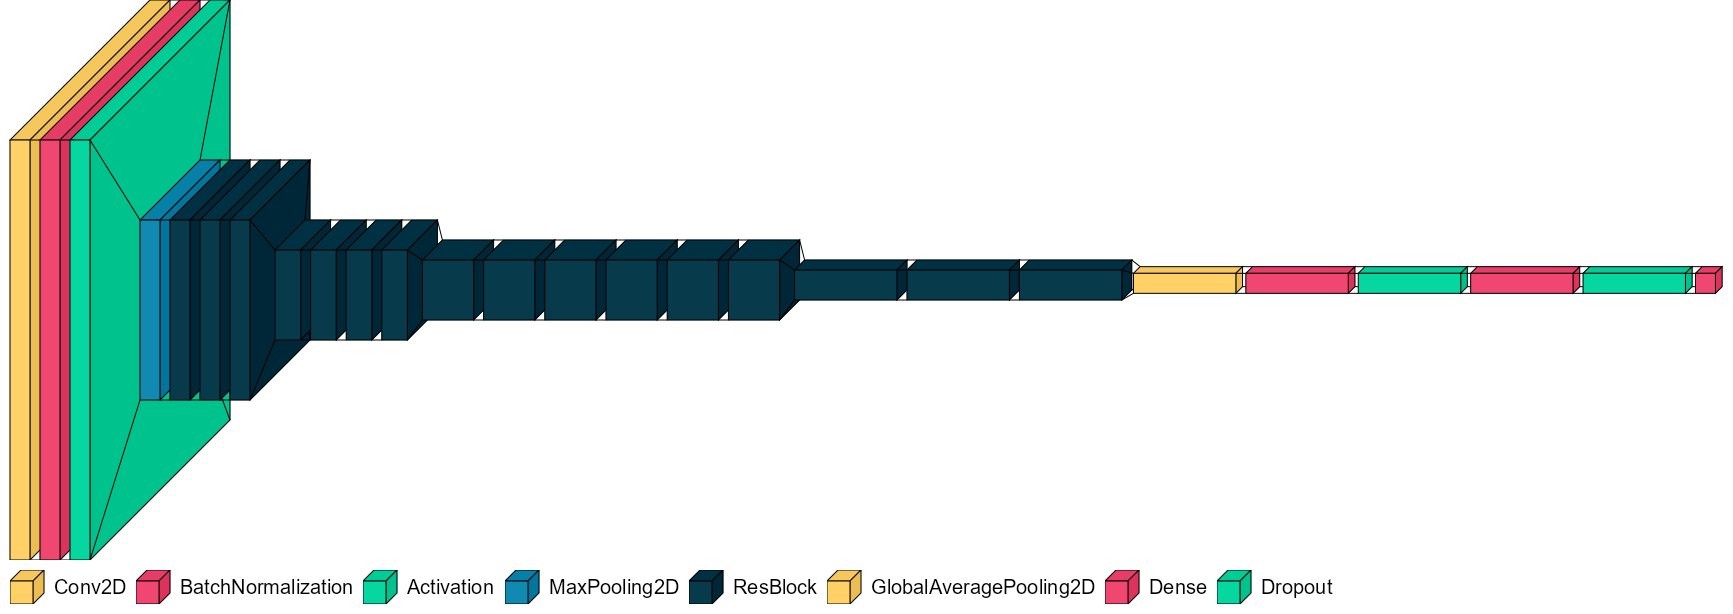

In [18]:
resnet = ResNet34()
resnet.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
resnet.build(input_shape=(64,28, 28, 1))
resnet.call(Input((28, 28, 1)))

resnet.summary()

# visualise model
font = ImageFont.truetype("arial.ttf", 20)
display(visualkeras.layered_view(resnet,to_file='../part_a/images/models/resnet.png',legend=True,font=font,scale_xy=30,scale_z=0.2,max_xy=1000))

In [ ]:
tf.keras.backend.clear_session()

### Model Training


#### Vanilla Model

In [20]:
resnet = ResNet34()
resnet.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
resnet.build(input_shape=(64,28, 28, 1))
resnet.call(Input((28, 28, 1)))

resnet_vanilla_model = resnet.fit(train_ds, epochs=100, verbose=1, validation_data=valid_ds, 
                        callbacks=[resnet.callbacks,CSVLogger('../part_a/results/resnet/resnet_vanilla.csv')])
resnet.evaluate(test_ds) 
tf.keras.backend.clear_session()



Learning rate:  0.001
Epoch 1/100
391/391 [==============================] - 33s 70ms/step - loss: 0.6470 - categorical_accuracy: 0.7764 - val_loss: 0.9912 - val_categorical_accuracy: 0.6747 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
391/391 [==============================] - 25s 65ms/step - loss: 0.3955 - categorical_accuracy: 0.8624 - val_loss: 0.9497 - val_categorical_accuracy: 0.7388 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
391/391 [==============================] - 25s 65ms/step - loss: 0.3432 - categorical_accuracy: 0.8812 - val_loss: 0.4394 - val_categorical_accuracy: 0.8415 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
391/391 [==============================] - 25s 65ms/step - loss: 0.3090 - categorical_accuracy: 0.8908 - val_loss: 0.4614 - val_categorical_accuracy: 0.8524 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
391/391 [==============================] - 26s 66ms/step - loss: 0.2806 - categorical_accuracy: 0.9019 - val_loss: 0.4138 - val_categorical_accuracy: 

#### Basic Augmentation Model

In [ ]:
# resnet = ResNet34()
# resnet.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# resnet.build(input_shape=(64,28, 28, 1))
# resnet.call(Input((28, 28, 1)))

# resnet_basic_model = resnet.fit(basic_augmentation, epochs=30, verbose=1, validation_data=valid_ds, 
#                     callbacks=[resnet.callbacks,CSVLogger('../part_a/results/resnet/resnet_basic.csv')])
# resnet.evaluate(test_ds) 
# tf.keras.backend.clear_session()


Epoch 1/100
782/782 [==============================] - 96s 115ms/step - loss: 0.7409 - categorical_accuracy: 0.7351 - val_loss: 0.4086 - val_categorical_accuracy: 0.8530
Epoch 2/100
782/782 [==============================] - 90s 115ms/step - loss: 0.5173 - categorical_accuracy: 0.8185 - val_loss: 0.4100 - val_categorical_accuracy: 0.8506
Epoch 3/100
782/782 [==============================] - 97s 124ms/step - loss: 0.4472 - categorical_accuracy: 0.8424 - val_loss: 0.3008 - val_categorical_accuracy: 0.8933
Epoch 4/100
782/782 [==============================] - 91s 117ms/step - loss: 0.4105 - categorical_accuracy: 0.8534 - val_loss: 0.3459 - val_categorical_accuracy: 0.8709
Epoch 5/100
782/782 [==============================] - 93s 118ms/step - loss: 0.3893 - categorical_accuracy: 0.8625 - val_loss: 0.3813 - val_categorical_accuracy: 0.8613
Epoch 6/100
782/782 [==============================] - 97s 124ms/step - loss: 0.3659 - categorical_accuracy: 0.8687 - val_loss: 0.2693 - val_categoric

KeyboardInterrupt: 

#### CutMix Augmentation Model

In [21]:
resnet = ResNet34()
resnet.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
resnet.build(input_shape=(64,28, 28, 1))
resnet.call(Input((28, 28, 1)))

resnet_cutmix_model = resnet.fit(cutmix, epochs=100, verbose=1, validation_data=valid_ds, 
                    callbacks=[resnet.callbacks,CSVLogger('../part_a/results/resnet/resnet_cutmix.csv')])
resnet.evaluate(test_ds)

tf.keras.backend.clear_session()


Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 57s 67ms/step - loss: 1.0570 - categorical_accuracy: 0.6745 - val_loss: 0.4161 - val_categorical_accuracy: 0.8503 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 50s 64ms/step - loss: 0.8806 - categorical_accuracy: 0.7393 - val_loss: 0.3292 - val_categorical_accuracy: 0.8828 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 50s 64ms/step - loss: 0.8171 - categorical_accuracy: 0.7564 - val_loss: 0.3176 - val_categorical_accuracy: 0.8896 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 49s 63ms/step - loss: 0.7994 - categorical_accuracy: 0.7612 - val_loss: 0.3472 - val_categorical_accuracy: 0.8782 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 48s 61ms/step - loss: 0.7848 - categorical_accuracy: 0.7604 - val_loss: 0.2734 - val_categorical_accuracy: 

#### MixUp Augmentation Model

In [22]:
resnet = ResNet34()
resnet.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
resnet.build(input_shape=(64,28, 28, 1))
resnet.call(Input((28, 28, 1)))

resnet_mixup_model = resnet.fit(mixup, epochs=100, verbose=1, validation_data=valid_ds, callbacks=[resnet.callbacks,CSVLogger("../part_a/results/resnet/resnet_mixup.csv")])

resnet.evaluate(test_ds)    

tf.keras.backend.clear_session()


Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 56s 64ms/step - loss: 0.8883 - categorical_accuracy: 0.7611 - val_loss: 0.4150 - val_categorical_accuracy: 0.8526 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 51s 65ms/step - loss: 0.6986 - categorical_accuracy: 0.8255 - val_loss: 0.4422 - val_categorical_accuracy: 0.8387 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 49s 62ms/step - loss: 0.6568 - categorical_accuracy: 0.8343 - val_loss: 0.3119 - val_categorical_accuracy: 0.8830 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 51s 65ms/step - loss: 0.6144 - categorical_accuracy: 0.8451 - val_loss: 0.3515 - val_categorical_accuracy: 0.8727 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 49s 62ms/step - loss: 0.5883 - categorical_accuracy: 0.8523 - val_loss: 0.2874 - val_categorical_accuracy: 

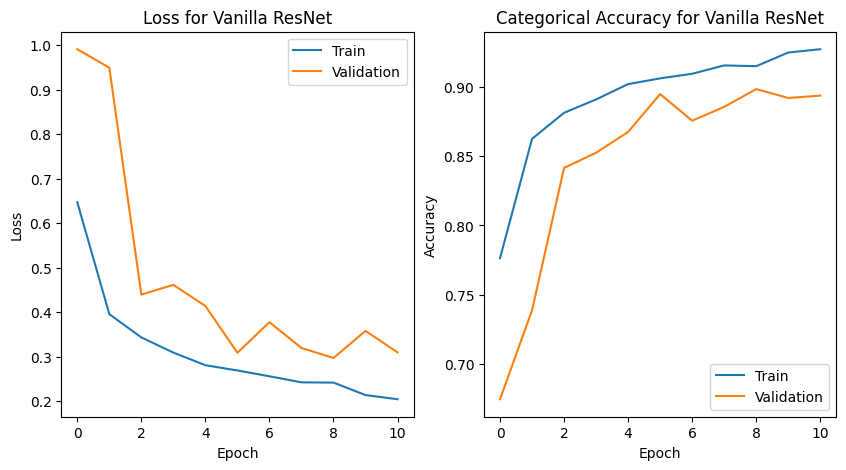

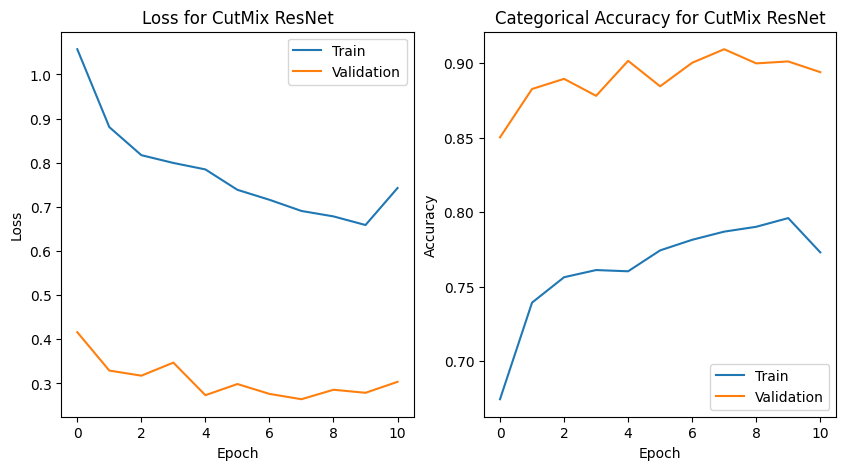

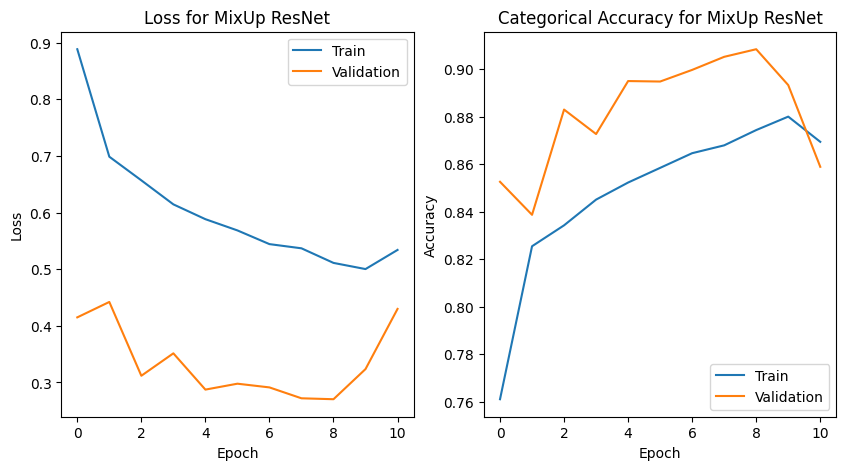

In [23]:
plot = PlotResults(
    [resnet_vanilla_model,resnet_cutmix_model,resnet_mixup_model],
    ['Vanilla ResNet','CutMix ResNet','MixUp ResNet'])
    
plot.plot()

### Model Analysis
Simply put, we can observe that the model seems to top out at ~90%. At roughly 23 million parameters, we can observe that this ResNet34 model actually has similar to neglible differences in the performance compared with our baseline model.

A reason for this may be due to the initial `Conv2D` layer immediately resizing the image from 28x28 to 14x14. Doing this reduces the resolution and therefore reduces the numbers of features present within the data points. As such, the NN is not able to pickup (as accurately) the features present within each image. 


This causes 2 issues:
1. Curse of dimensionality. Large dimensional vectors are almost equally spaced and hence are difficult to separate by a classifier.

2. A lot more number of parameters are now needed due to a larger network (for larger input vector). Training a larger number of parameters is difficult and will need many more training data, and number of iterations. Despite all regularization efforts, They will tend to overfit even if you train them well as compared to the lesser number of parameters of grey scale case.

As such, the ResNet34 Model is not able to perform better than the baseline model, and we will not be using this model to proceed with hyperparameter tuning.

# Model Improvement & Hyperparameter Tuning

## [Talos](https://github.com/autonomio/talos)

Talos comes on top in terms of intuitive, easy-to-learn, highly permissive access to critical hyperparameter optimization capabilities. Key features include:

1. Single-line optimize-to-predict pipeline talos.Scan(x, y, model, params).predict(x_test, y_test)
2. Automated hyperparameter optimization
3. Model generalization evaluator
4. Experiment analytics
5. Pseudo, Quasi, and Quantum Random search options
6. Grid search
7. Probabilistic optimizers
8. Single file custom optimization strategies
9. Dynamically change optimization strategy during experiment
10. Support for man-machine cooperative optimization strategy
11. Model candidate generality evaluation
12. Live training monitor
13. Experiment analytics


### Talos Pipeline
![talos_workflow](images/talos_workflow.png)

In [26]:
import talos

class Talos_param(Model_init):
    def __init__(self):
        super().__init__()
        self.Input = Input
        self.Rescaling = Rescaling
        self.Conv2D = Conv2D
        self.AveragePooling2D = AveragePooling2D
        self.MaxPooling2D = MaxPooling2D
        self.Flatten = Flatten
        self.Dense = Dense
        self.BatchNormalization = BatchNormalization
        self.Dropout = Dropout
        self.p = \
        {
            'activation': ['relu', 'elu','sigmoid'],
            'optimizer': ['Adam', 'Adagrad','adamax','RMSprop'],
            'learning_rate': [0.001, 0.01, 0.1],
            'label_smoothing': [0.1, 0.2, 0.3],
        }
    # lenet model architecture
    def architecture(self):
        input1 = self.Input((28, 28, 1))
        x = self.Rescaling(1/255)(input1) #normalise input
        x = self.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation= self.p['activation'])(x)
        x = self.BatchNormalization()(x) 
        x = self.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
        x = self.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation=self.p['activation'],padding="same")(x)
        x = self.BatchNormalization()(x)
        x = self.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
        x = self.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation=self.p['activation'],padding="same")(x)
        x = self.BatchNormalization()(x)
        x = self.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation=self.p['activation'],padding="same")(x)
        x = self.BatchNormalization()(x)
        x = self.Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation=self.p['activation'],padding="same")(x)
        x = self.BatchNormalization()(x)
        x = self.MaxPooling2D(pool_size=(1,1), strides=(2,2))(x)
        x = self.Flatten()(x)
        x = self.Dense(units=4096, activation =self.p['activation'])(x)
        x = self.Dropout(0.5)(x)
        x = self.Dense(units=4096, activation =self.p['activation'])(x)
        x = self.Dropout(0.5)(x)
        output = self.Dense(units=10, activation='softmax')(x)
        
        # instantiate model
        model = Model(inputs=input1, outputs=output)
        
        # compile model``
        model.compile(
            optimizer=self.p['optimizer'](learning_rate=self.p['learning_rate'],decay=1e-6),
            loss=keras.losses.CategoricalCrossentropy(label_smoothing=self.p['label_smoothing']),
            metrics=["categorical_accuracy"])

            # make sure history object is returned by model.fit()
        out = model.fit(mixup, epochs=50, verbose=1, validation_data=valid_ds, callbacks=[self.early_stopping, self.reduce_lr])
        
        # modify the output model
        return out, model
                
                

In [ ]:
# hyperparameters = Talos_param()
# # hyperparameters_model = 
# talos.Scan(hyperparameters.architecture())
# # hyperparameters_model.visualise(hyperparameters_model,'alexnet_hyper.png')

### Talos Conclusion

The documentation for Talos only allows for X and y datasets, and doesn't have native support for TensorFlow Datasets (TFDS), hence, we will proceed with keras-tuner for hyperparameter tuning

## Keras Tuner

KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search. 

We can easily configure our search space with a define-by-run syntax, then leverage one of the available search algorithms to find the best hyperparameter values for your models. 

KerasTuner comes with:
1. Bayesian Optimization
2. Hyperband
3. Random Search 



In [ ]:
tf.keras.backend.clear_session()

### RandomSearch Tuning
We perform RandomSearch Hyperparameter Tuning for the AlexNet and ResNet-34 Models

In [27]:
import math
import keras_tuner
import keras.layers as Layers
# import LearningRateScheduler
from keras.callbacks import LearningRateScheduler,CSVLogger


# defining hyperparameter class for alexnet and resnet
class Hyper:
    def __init__(self,mod):
        self.mod = mod
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,min_delta=1)
        # reduce learning rate
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
        self.decay = LearningRateScheduler(self.lr_decay) # learning rate decay
        self.callbacks =[self.early_stopping,self.reduce_lr,self.decay]
        
    def lr_decay(self,epoch):
        initial_lrate = 0.1
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
        return lrate

        
    def call_existing_architecture(self,activation,lr,smoothing,mod,pooling):
        if mod == 'alexnet':
            # alexnet model architecture
            input1 = Input((28, 28, 1))
            x = Rescaling(1/255)(input1) #normalise input
            x = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation=activation)(x)
            x = BatchNormalization()(x) 
            x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
            x = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation=activation,padding="same")(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
            x = Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation=activation,padding="same")(x)
            x = BatchNormalization()(x)
            x = Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation=activation,padding="same")(x)
            x = BatchNormalization()(x)
            x = Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation=activation,padding="same")(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(pool_size=(1,1), strides=(2,2))(x)
            x = Flatten()(x)
            x = Dense(units=4096, activation =activation)(x)
            x = Dropout(0.5)(x)
            x = Dense(units=4096, activation=activation)(x)
            x = Dropout(0.5)(x)
            output = Dense(units=10, activation='softmax')(x)
            model = Model(inputs=input1, outputs=output)
            model.compile(
                    optimizer= keras.optimizers.Adagrad(learning_rate=lr,decay=1e-6),
                    loss=keras.losses.CategoricalCrossentropy(label_smoothing=smoothing),
                    metrics=["categorical_accuracy"])
            return model

        elif mod == 'resnet':
            # resblock for resnet
            class ResBlock(Model):
                def __init__(self, channels, stride=1):
                    super(ResBlock, self).__init__(name='ResBlock')
                    self.flag = (stride != 1)
                    self.conv1 = Conv2D(channels, 3, stride, padding='same')
                    self.bn1 = BatchNormalization()
                    self.conv2 = Conv2D(channels, 3, padding='same')
                    self.bn2 = BatchNormalization()
                    self.relu = Activation('relu')
                    if self.flag:
                        self.bn3 = BatchNormalization()
                        self.conv3 = Conv2D(channels, 1, stride)
                    
                def call(self, x):
                    x1 = self.conv1(x)
                    x1 = self.bn1(x1)
                    x1 = self.relu(x1)
                    x1 = self.conv2(x1)
                    x1 = self.bn2(x1)
                    if self.flag:
                        x = self.conv3(x)
                        x = self.bn3(x)
                    x1 = Layers.add([x, x1])
                    x1 = self.relu(x1)
                    return x1

            # ResNet model architecture
            class ResNet34(Model):
                def __init__(self):
                    super(ResNet34, self).__init__(name='ResNet34')

                    self.conv1 = Conv2D(64, 7, 2, padding='same')
                    self.bn = BatchNormalization()
                    self.relu = Activation('relu')
                    self.mp1 = MaxPooling2D(3, 2)

                    self.conv2_1 = ResBlock(64)
                    self.conv2_2 = ResBlock(64)
                    self.conv2_3 = ResBlock(64)

                    self.conv3_1 = ResBlock(128, 2)
                    self.conv3_2 = ResBlock(128)
                    self.conv3_3 = ResBlock(128)
                    self.conv3_4 = ResBlock(128)

                    self.conv4_1 = ResBlock(256, 2)
                    self.conv4_2 = ResBlock(256)
                    self.conv4_3 = ResBlock(256)
                    self.conv4_4 = ResBlock(256)
                    self.conv4_5 = ResBlock(256)
                    self.conv4_6 = ResBlock(256)

                    self.conv5_1 = ResBlock(512, 2)
                    self.conv5_2 = ResBlock(512)
                    self.conv5_3 = ResBlock(512)


                    self.pool = GlobalAveragePooling2D() #global pooling to aggressively summarize the presence of a feature in an image.
                    self.fc1 = Dense(512, activation=activation)
                    self.dp1 = Dropout(0.5)
                    self.fc2 = Dense(512, activation=activation)
                    self.dp2 = Dropout(0.5)
                    self.fc3 = Dense(10, activation='softmax')

                def call (self, x):
                    x = self.conv1(x)
                    x = self.bn(x)
                    x = self.relu(x)
                    x = self.mp1(x)

                    x = self.conv2_1(x)
                    x = self.conv2_2(x)
                    x = self.conv2_3(x)

                    x = self.conv3_1(x)
                    x = self.conv3_2(x)
                    x = self.conv3_3(x)
                    x = self.conv3_4(x)

                    x = self.conv4_1(x)
                    x = self.conv4_2(x)
                    x = self.conv4_3(x)
                    x = self.conv4_4(x)
                    x = self.conv4_5(x)
                    x = self.conv4_6(x)

                    x = self.conv5_1(x)
                    x = self.conv5_2(x)
                    x = self.conv5_3(x)
                    
                    if pooling == "avg":
                        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
                    elif pooling == "max":
                        x = layers.GlobalMaxPooling2D(name="max_pool")(x)
                    x = self.fc1(x)
                    x = self.dp1(x)
                    x = self.fc2(x)
                    x = self.dp2(x)
                    x = self.fc3(x)
                    return x

            resnet = ResNet34()        
            resnet.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=keras.losses.CategoricalCrossentropy(label_smoothing=smoothing), metrics=['categorical_accuracy'])
            resnet.build(input_shape=(64,28, 28, 1))   
            resnet.call(Input((28, 28, 1)))
            return resnet

    def build_model(self,hp):
        # build model with hyperparameters
        activation = hp.Choice("activation", ["relu", "tanh","sigmoid","swish"])
        lr = hp.Choice("lr", [0.1, 0.01,0.001,0.002,0.004])
        smoothing = hp.Choice("label_smoothing", [0.1, 0.2,0.3,0.4])
        mod = self.mod
        pooling = hp.Choice("pooling", ["avg", "max"])
        # call existing model-building code with the hyperparameter values.
        model = self.call_existing_architecture(
            activation=activation,
            lr=lr,
            smoothing=smoothing,
            mod=mod,
            pooling=pooling
        )
        return model

        


#### AlexNet


In [ ]:
# instantiate tuner for alexnet randomsearch
random_alex = Hyper('alexnet')
random_alex.build_model(keras_tuner.HyperParameters())

tuner_random_alex = keras_tuner.RandomSearch(
    hypermodel=random_alex.build_model,
    objective="val_categorical_accuracy",
    max_trials=10,
    executions_per_trial=3,
    overwrite=True,
    directory="hypertuning",
    project_name="random/alexnet",
)

tuner_random_alex.search_space_summary()
tuner_random_alex.search(mixup, epochs=20, validation_data=valid_ds, 
callbacks=[random_alex.callbacks,CSVLogger('../part_a/hypertuning/random/alexnet/alexnet.csv')])
tuner_random_alex.results_summary()

#### ResNet34


In [ ]:
# instantiate tuner for alexnet randomsearch
random_resnet = Hyper('resnet')
random_resnet.build_model(keras_tuner.HyperParameters())

tuner_random_resnet = keras_tuner.RandomSearch(
    hypermodel=random_resnet.build_model,
    objective="val_categorical_accuracy",
    max_trials=10,
    executions_per_trial=3,
    overwrite=True,
    directory="hypertuning",
    project_name="random/resnet",
)

tuner_random_resnet.search_space_summary()
tuner_random_resnet.search(mixup, epochs=20, validation_data=valid_ds, callbacks=
[random_resnet.callbacks,CSVLogger('../part_a/hypertuning/random/resnet/resnet.csv')])
tuner_random_resnet.results_summary()


### Hyperband Tuning

Hyperband focuses on speeding up random search through adaptive resource allocation and early-stopping. 

It formulates hyperparameter optimization as a pure-exploration non-stochastic infinite-armed bandit problem where a predefined resource like iterations, data samples, or features is allocated to randomly sampled configurations.

[Credit](https://jmlr.org/papers/v18/16-558.html)

#### AlexNet

In [ ]:
# instantiate tuner for alexnet hyperband search
band_alex = Hyper('alexnet')
band_alex.build_model(keras_tuner.HyperParameters())

tuner_band_alex = keras_tuner.Hyperband(
    hypermodel=band_alex.build_model,
    objective="val_categorical_accuracy",
    max_epochs=20,
    factor=3,
    hyperband_iterations=10,
    overwrite=True,
    directory="hypertuning",
    project_name="hyperband/alexnet",
)

tuner_band_alex.search_space_summary()
tuner_band_alex.search(mixup, epochs=20, validation_data=valid_ds, callbacks=
[band_alex.callbacks,CSVLogger('../part_a/hypertuning/hyperband/alexnet/alexnet.csv')])
tuner_band_alex.results_summary()

#### ResNet34

In [ ]:
# instantiate tuner for alexnet hyperband search
band_resnet = Hyper('resnet')
band_resnet.build_model(keras_tuner.HyperParameters())

tuner_band_resnet = keras_tuner.Hyperband(
    hypermodel=band_resnet.build_model,
    objective="val_categorical_accuracy",
    max_epochs=20,
    factor=3,
    hyperband_iterations=10,
    overwrite=True,
    directory="hypertuning",
    project_name="hyperband/resnet",
)

tuner_band_resnet.search_space_summary()
tuner_band_resnet.search(mixup, epochs=20, validation_data=valid_ds, callbacks=
[band_resnet.callbacks,CSVLogger('../part_a/hypertuning/hyperband/resnet/resnet.csv')])
tuner_band_resnet.results_summary()

Trial 4 Complete [00h 02m 54s]
val_categorical_accuracy: 0.10279999673366547

Best val_categorical_accuracy So Far: 0.8927000164985657
Total elapsed time: 00h 11m 38s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
tanh              |relu              |activation
0.01              |0.001             |lr
0.1               |0.1               |label_smoothing
avg               |avg               |pooling
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
101/782 [==>...........................] - ETA: 46s - loss: 2.6310 - categorical_accuracy: 0.2386

KeyboardInterrupt: 

### Bayesian Optimisation Tuning
Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. 

As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below

![bayesian](images/bayesian.png)

[Credit](https://github.com/fmfn/BayesianOptimization)

#### AlexNet

In [ ]:
# instantiate tuner for alexnet hyperband search
bayesian_alex = Hyper('alexnet')
bayesian_alex.build_model(keras_tuner.HyperParameters())

tuner_bayesian_alex = keras_tuner.Hyperband(
    hypermodel=bayesian_alex.build_model,
    objective="val_categorical_accuracy",
    max_epochs=20,
    factor=3,
    hyperband_iterations=10,
    directory="hypertuning",
    project_name="bayesian/alexnet",
)

tuner_bayesian_alex.search_space_summary()
tuner_bayesian_alex.search(mixup, epochs=20, validation_data=valid_ds, callbacks=
[bayesian_alex.callbacks,CSVLogger('../part_a/hypertuning/bayesian/alexnet/alexnet.csv')])
tuner_bayesian_alex.results_summary()

#### ResNet34

In [28]:
# instantiate tuner for alexnet hyperband search
bayesian_resnet = Hyper('alexnet')
bayesian_resnet.build_model(keras_tuner.HyperParameters())

tuner_resnet_alex = keras_tuner.Hyperband(
    hypermodel=bayesian_resnet.build_model,
    objective="val_categorical_accuracy",
    max_epochs=20,
    factor=3,
    hyperband_iterations=10,
    directory="hypertuning",
    project_name="bayesian/resnet",
)

tuner_resnet_alex.search_space_summary()
tuner_resnet_alex.search(mixup, epochs=20, validation_data=valid_ds, callbacks=
[bayesian_resnet.callbacks,CSVLogger('../part_a/hypertuning/hyperband/resnet/resnet.csv')])
tuner_resnet_alex.results_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'swish'], 'ordered': False}
lr (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.002, 0.004], 'ordered': True}
label_smoothing (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4], 'ordered': True}
pooling (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
tanh              |?                 |activation
0.1               |?                 |lr
0.1               |?                 |label_smoothing
max               |?                 |pooling
3                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/3
781/782 [==========

NotFoundError: Failed to create a NewWriteableFile: ../part_a/hypertuning/hyperband/resnet/resnet.csv : The system cannot find the path specified.
; No such process

## Final Model

In [9]:
# credit https://github.com/safwankdb/ResNet34-TF2/blob/master/model.py
# modified implementation of resnet34 model referencing the above github repo

from keras.activations import relu
from keras import layers as Layers
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator



class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = Activation('relu')
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)
        
    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,min_delta=0.001)
        # reduce learning rate
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
        self.decay = LearningRateScheduler(self.lr_decay) # learning rate decay
        self.callbacks =[self.early_stopping,self.reduce_lr,self.decay] # list of callbacks

        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = Activation('relu')
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)


        self.pool = GlobalAveragePooling2D() #global pooling to aggressively summarize the presence of a feature in an image.
        self.fc1 = Dense(512, activation='relu')
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512, activation='relu')
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(10, activation='softmax')
    def lr_decay(self,epoch): # learning rate decay
            initial_lrate = 0.001
            drop = 0.5
            epochs_drop = 30
            lrate = initial_lrate * math.pow(drop,  
                math.floor((1+epoch)/epochs_drop))
            print('Learning rate: ', lrate)
            return lrate
    def call (self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x


c:\Users\justi\anaconda3\envs\tensor4\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "ResNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        3200      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 64)         0         
 )                                                               
                                                                 
 ResBlock (ResBlock)         (None, 6, 6, 64)          74368     
                                                                 
 ResBlock (ResBlock)         (None, 6, 6, 64)          743

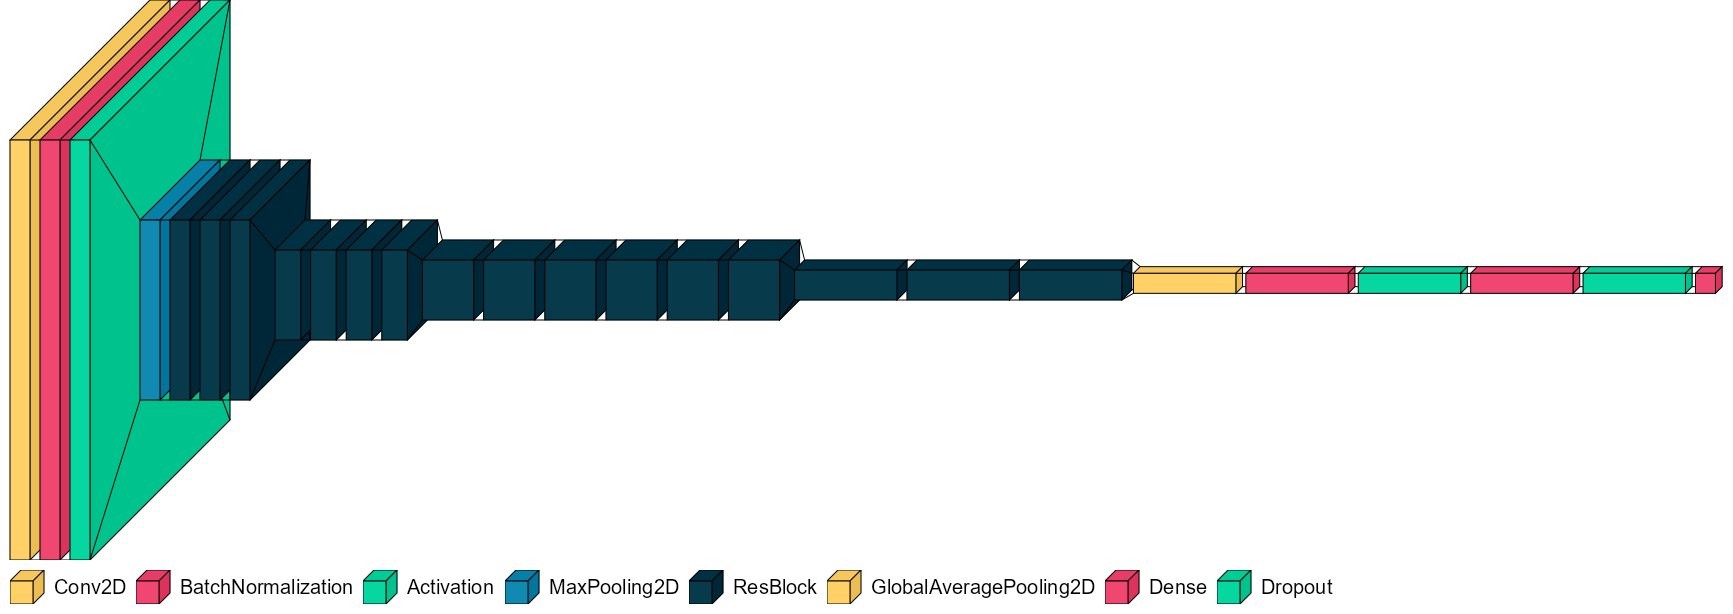

In [10]:
resnet = ResNet34()
resnet.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
resnet.build(input_shape=(64,28, 28, 1))
resnet.call(Input((28, 28, 1)))

resnet.summary()

# visualise model
font = ImageFont.truetype("arial.ttf", 20)
display(visualkeras.layered_view(resnet,to_file='../part_a/images/models/resnet.png',legend=True,font=font,scale_xy=30,scale_z=0.2,max_xy=1000))

In [11]:
resnet = ResNet34()
resnet.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
resnet.build(input_shape=(64,28, 28, 1))
resnet.call(Input((28, 28, 1)))

resnet_cutmix_model = resnet.fit(cutmix, epochs=100, verbose=1, validation_data=valid_ds, 
                    callbacks=[resnet.callbacks,CSVLogger('../part_a/results/resnet/resnet_cutmix.csv')])
resnet.evaluate(test_ds)

tf.keras.backend.clear_session()


Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 61s 65ms/step - loss: 1.0595 - categorical_accuracy: 0.6708 - val_loss: 0.5390 - val_categorical_accuracy: 0.8172 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 49s 63ms/step - loss: 0.8911 - categorical_accuracy: 0.7391 - val_loss: 0.3305 - val_categorical_accuracy: 0.8807 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 48s 62ms/step - loss: 0.8462 - categorical_accuracy: 0.7473 - val_loss: 0.3778 - val_categorical_accuracy: 0.8634 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 48s 62ms/step - loss: 0.7935 - categorical_accuracy: 0.7620 - val_loss: 0.3180 - val_categorical_accuracy: 0.8900 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 48s 61ms/step - loss: 0.8400 - categorical_accuracy: 0.7444 - val_loss: 0.5064 - val_categorical_accuracy: 

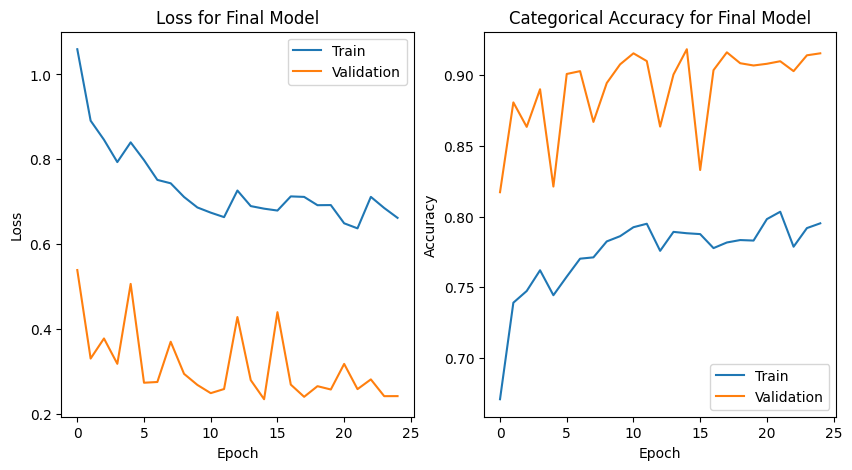

In [12]:
plot = PlotResults(
    [resnet_cutmix_model],
    ['Final Model'])
    
plot.plot()

# Conclusion & Takeaways
In summary, the best performing model that did not overfit was produced with a custom ResNet34 Implementation coupled with CutMix Augmented data.

After testing out various Neural Network Architectures, I found that the ResNet50 Model was the best performing model out of all. However, this is not to say that the other models were not good. In fact, the AlexNet Model was able to perform better than the ResNet50 Model, but it was not able to generalise well. 

I also decided to not merge the augmented data with the original train data as I was afraid that it would lead to overfitting. This is due to the fact that the data is already soft-label encoded. This soft-label encoding is a form of regularisation, and as such, I decided to not merge the augmented data with the original train data. 

After experimentation, I found Residual Nerual Networks to perform better, and I am satisified with the current model that I have as the architecture tuning and hyperparameter tuning increased the accuracy as compared to the baseline model.

Understandably, there is also more room for exploration in terms of the learning rate scheduler, optimizer and certain architectural improvements. However, I chose not to explore these areas as I was short on time and resources.
